In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time 
import datetime
import shutil

%matplotlib inline

class RUN:
    timePerOrbit = 110*24.95
            
    def __init__(self, dataFrame):
        
        
        self.df = dataFrame
        self.events = len(self.df)

        
        self.orbitMin  = self.df['orbit'][:1].values[0]
        self.orbitMax  = self.df['orbit'][-1:].values[0] 
        self.nOrbits= self.orbitMax - self.orbitMin
        self.rectime   = self.nOrbits * RUN.timePerOrbit # in ns
        self.rectimeSECONDS   = self.nOrbits * RUN.timePerOrbit * 10**(-9) # in s
        
        if (self.df['run'][0] == self.df['run'][-1:].values[0]): # This code is not intended for use on merged runs
            self.run = self.df['run'][0]   
            TimeLogPath = "https://raw.githubusercontent.com/theofil/dscout/master/analysis/runsDateTimeLog.txt"
            TimeLog = pd.read_csv(TimeLogPath, delimiter = ', ', engine = 'python')

            for i in range(len(TimeLog['run'])):
                if TimeLog['run'][i] == self.run : 
                    index = i 
                    break

            duration = TimeLog['duration'][index]
            self.tStart = TimeLog['time_start'][index]
            self.tEnd = TimeLog['time_end'][index]
            h, m, s=duration.split(":")
            durationSecs = datetime.timedelta(hours = int(h), minutes = int(m), seconds = int(s)).total_seconds()
    #       --------------------------        
            self.duration = durationSecs
            self.naiveRate = self.events/durationSecs # in seconds
    #       --------------------------    
    
    def rate(self, timeUnit = 1, graph = False, info = False):
        
        orbitMin = self.orbitMin 
        orbitMax = self.orbitMax
        df = self.df['orbit']
        timeUnit = timeUnit*1e9 # desired time in seconds
        orbitsPerTimeUnit = timeUnit/RUN.timePerOrbit
        bins=int(self.nOrbits/orbitsPerTimeUnit) 
#         Depending on the time unit, some runs might have   orbitsPerTimeUnit > self.nOrbits
        if bins == 0: bins = 1  
        timePerBin = self.rectime/bins
        muons=np.zeros(bins)
        sclice=np.array([orbitMin+ ((orbitMax-orbitMin)/bins)*i for i in range(bins+1)])

        # Count the events in the first orbit = orbitMin
        for orbit in df:
            if(orbit > orbitMin): break
            if(orbit == orbitMin): muons[0] += 1

        df = df[int(muons[0]):] # We already counted the first orbit
        i = 0
        for orbit in df:
            while not (orbit > sclice[i] and orbit <= sclice[i + 1]) and i < bins-1: # Note the <= in 'orbit <= slicePlusOne[i]'. 
                i = i + 1                                                              # It is needed to capture the last orbit.
            muons[i] += 1

        # Maximum Likelihood Estimation of Poisson parameter
        Nmuons = int(muons.sum()) 
        Ninterval = len(muons) # How many time intervals

        mu = muons.mean()
        med = np.median(muons)
        sigma = muons.std()
        MLE = Nmuons/Ninterval

        # 99% Confidence interval under gaussian approximation

        error = 2.58 * np.sqrt(MLE/Ninterval)
        lower = MLE-error
        upper = MLE+error
        
        if (info):
        
            print('timePerOrbit %2.1f ns '%RUN.timePerOrbit)
            print('orbitMin %d orbitMax %d'%(self.orbitMin, self.orbitMax))
            print('nOrbits %d '%self.nOrbits)
            print('total recording time %2.4f ns (~= %2.1f s)' %(self.rectime, self.rectime*1.e-9))
            print('orbitsPerTimeUnit = %2.3f'%orbitsPerTimeUnit)
            print("bins = %d" %bins)
            print('--------------------------------')
            print('mean = {:.2f}' .format(mu))
            print('median = {:d}'.format(int(med)))             
            print('sample std = {:.2f}'.format( sigma))
            #print('Gaussian 99% Confidence Interval = [{:.2f} , {:.2f} ]'.format(lower, upper))
            
        if (graph):
            
            if style == 1:
                
                muons = pd.Series(muons)
                counts = muons.value_counts().sort_index()
                
                plt.figure(figsize=(8,8))
                plt.errorbar(counts.index, counts.values, xerr = None, yerr = np.sqrt(counts.values), fmt = 'o')
                plt.xlabel('Muons / %2.1f s'%(timePerBin*1.e-9), fontsize = 20) # latex can be entered in the label's string
                plt.ylabel('Frequency', fontsize = 20)

                plt.show()
                
            if style == 2:
            
                muons = np.array(muons)
                counts, binEdges = numpy.histogram(muons, bins=len(muons))

                bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                menStd     = np.sqrt(counts)
                width      = 1

                plt.figure(figsize=(8,8))
                plt.bar(bincenters, counts, width=width, color='b', ecolor = 'r', yerr=menStd, error_kw = {'alpha': 1})
                plt.xlabel('Muons / %2.1f s'%(timePerBin*1.e-9), fontsize = 20) # latex can be entered in the label's string
                plt.ylabel('Frequency', fontsize = 20)

                plt.show()

        return mu  # muons.mean() is the rate (events per timeUnit)


    def plotPhi(self, bins = 30):
        
        phiticks = [0.5*np.pi*i for i in range(-2,3)]
        plt.rc('font', size=22)
        plt.figure(figsize=(8,8))
        plt.hist(self.df['phi'], bins = bins, ec='black', histtype = 'stepfilled')
        plt.xticks(phiticks)
        plt.xlabel('$\phi$ [radians]')
        plt.ylabel('Muons')
        plt.title('Run [{}], Duration = {:.2f} min '.format(self.run, self.duration/60), size = 30)
        plt.show()
        
    def plotOrbit(self, bins = 100):
        
        plt.rc('font', size=22)
        plt.figure(figsize=(8,8))
        plt.hist(self.df['orbit'], bins = bins, ec='black', histtype = 'stepfilled')
        plt.xlabel('Orbit', size = 30)
        plt.ylabel('Muons', size = 30)
        plt.xticks(size = 20)
        plt.yticks(size = 20)
        plt.title('Run [{}], Duration = {:.2f} min '.format(self.run, self.duration/60), size = 30)
        plt.show()
        

In [18]:
def pair(df, x):

    dfns = df.shift(-x)
    dfps = df.shift(+x)

    logicOS1 = (df.bx == dfns.bx - x) & (df.orbit == dfns.orbit) & (df.charge*dfns.charge < 0)
    OS1 = df[logicOS1].copy()

    logicOS2 = (df.bx == dfps.bx + x) & (df.orbit == dfps.orbit) & (df.charge*dfps.charge < 0)
    OS2 = df[logicOS2].copy()

    OS1 = OS1.reset_index()
    OS2 = OS2.reset_index()

    OS = OS1.merge(OS2, left_on=OS1.index, right_on=OS2.index, suffixes=('_in', '_out'))

    logicSS1 = (df.bx == dfns.bx - x) & (df.orbit == dfns.orbit) & (df.charge*dfns.charge > 0)
    SS1 = df[logicSS1].copy()

    logicSS2 = (df.bx == dfps.bx + x) & (df.orbit == dfps.orbit) & (df.charge*dfps.charge > 0)
    SS2 = df[logicSS2].copy()

    SS1 = SS1.reset_index()
    SS2 = SS2.reset_index()

    SS = SS1.merge(SS2, left_on=SS1.index, right_on=SS2.index, suffixes=('_in', '_out'))

    # slim the dataframes
    def slimDataFrame(df):
        df = df.drop(['run_in', 'index_in','index_out','key_0','orbit_out'], axis=1)
        df = df.rename(columns = {'run_out':'run','orbit_in':'orbit'})
        if False: df = df.set_index(['run','orbit','bx_in'])
        return df

    OS = slimDataFrame(OS)
    SS = slimDataFrame(SS)
    return (OS, SS)

In [19]:
path = './data/allRuns/csv/'
def DurationFilter(path, cut):
    
    files = os.listdir(path)
    files = [f for f in files]

    # list to hold runs
    runList = []
#     rate = []
#     duration = []
#     rectime = []
    runNo = []
    for file in files:
        filepath = path+file
        df = pd.read_csv(filepath)
        runObj = RUN(df)
        
        if runObj.duration > cut:
            runList.append(runObj)
    return runList

In [20]:
runs = DurationFilter(path, 600)
len(runs)

63

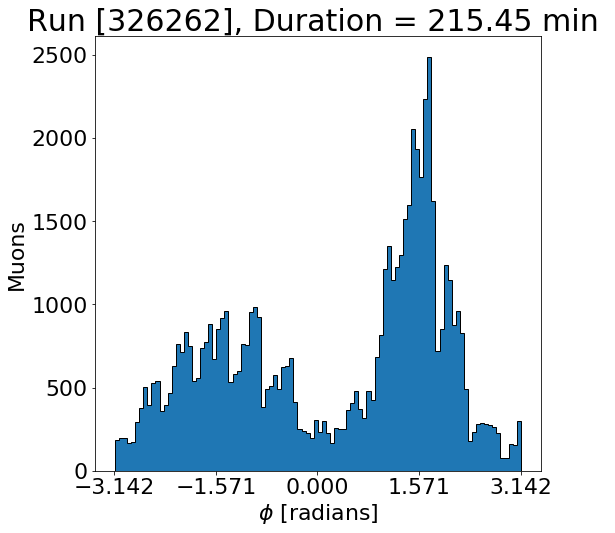

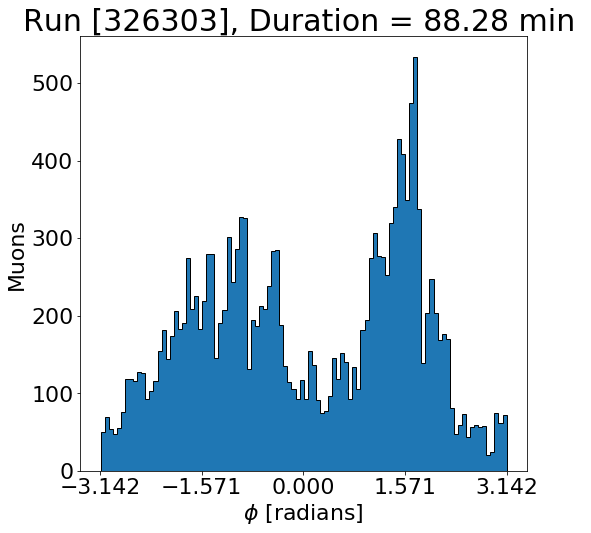

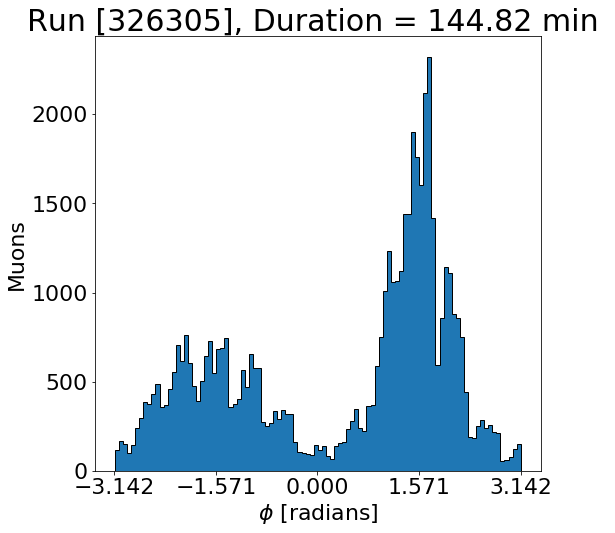

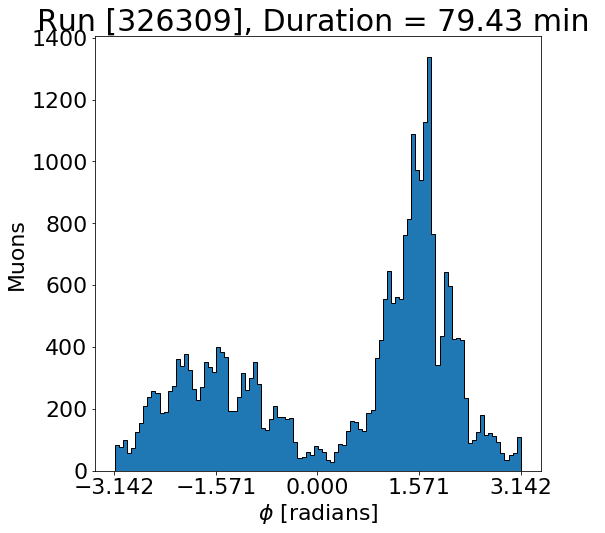

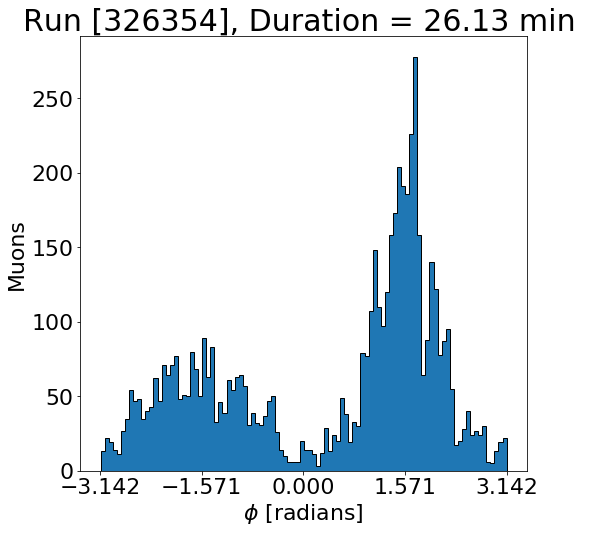

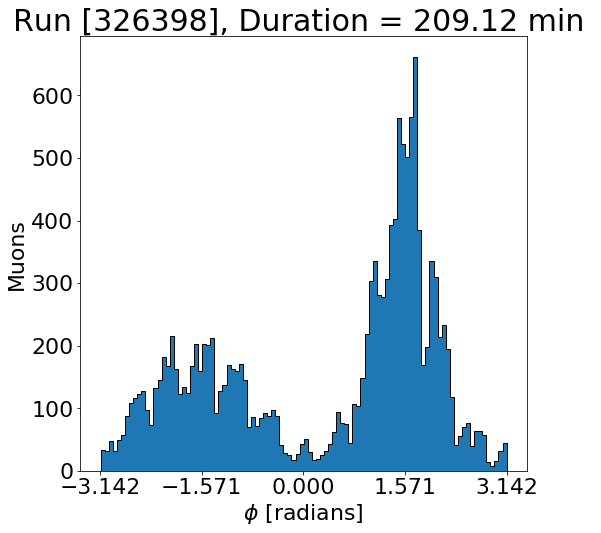

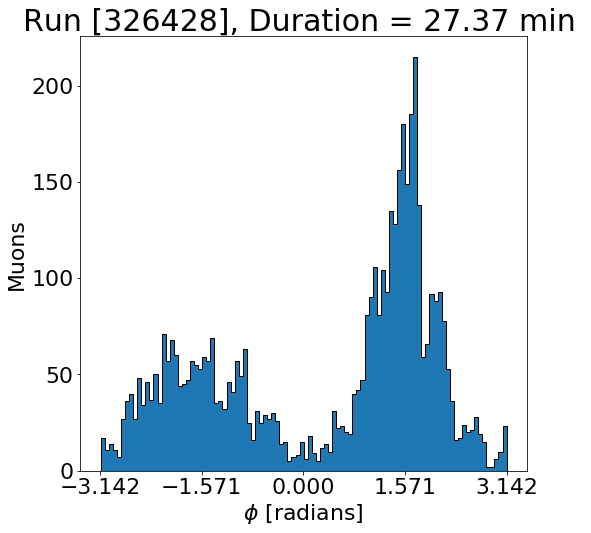

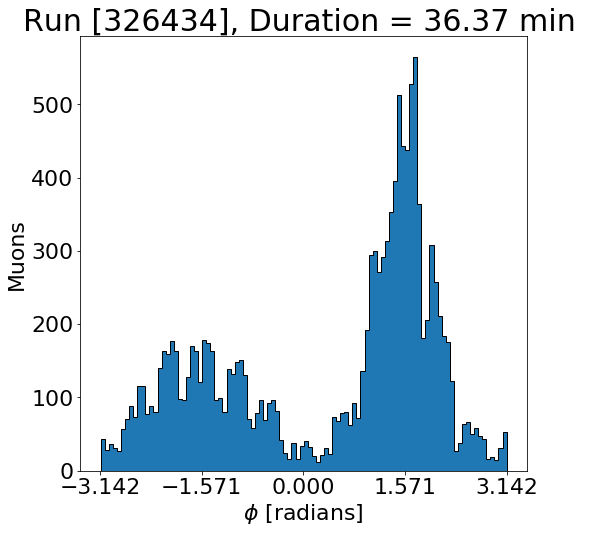

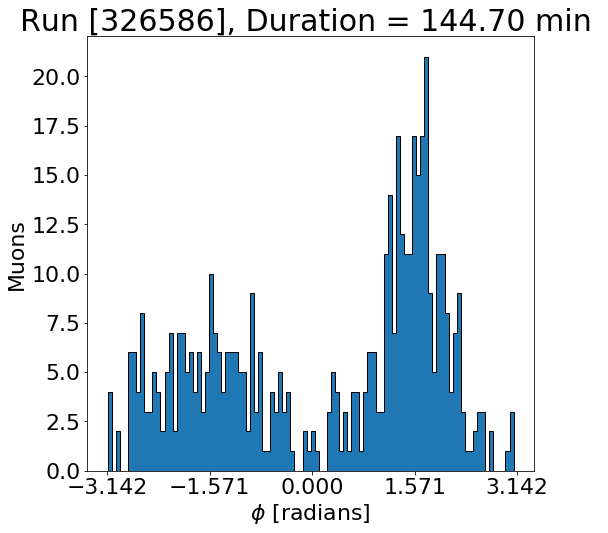

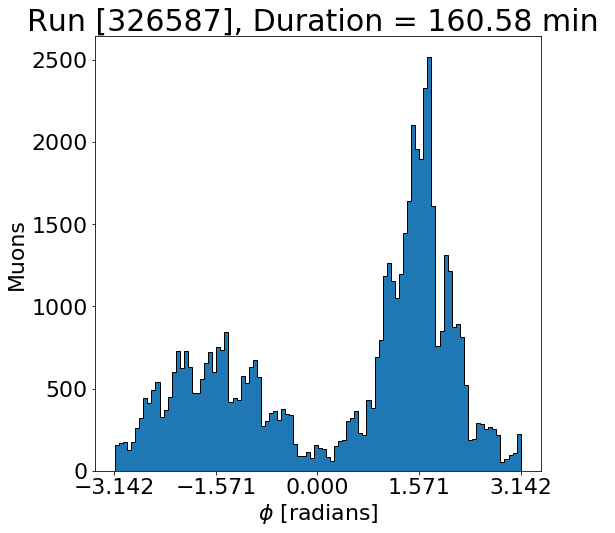

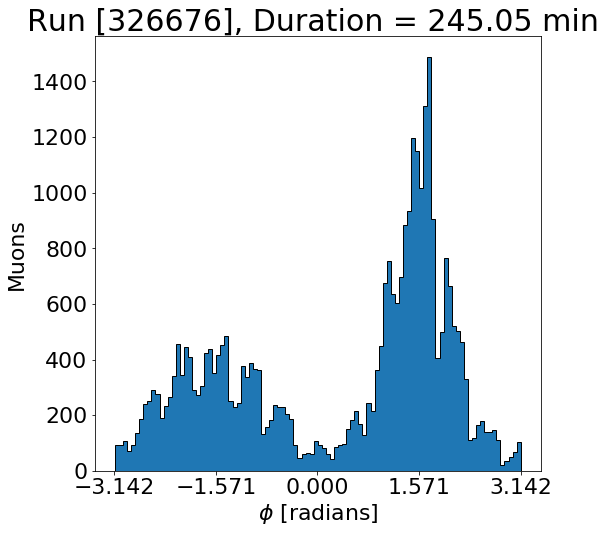

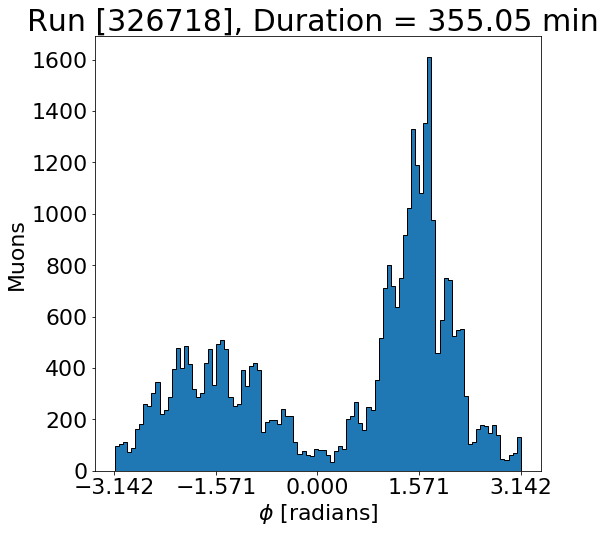

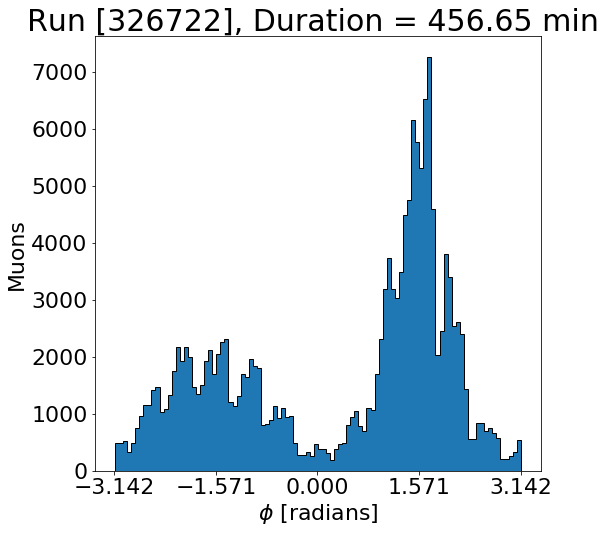

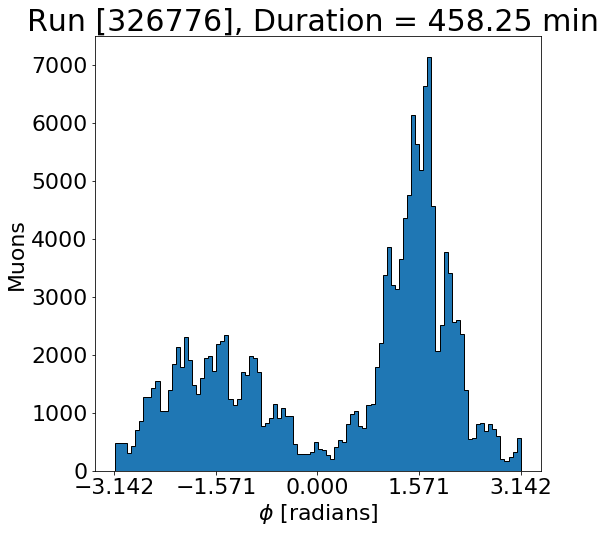

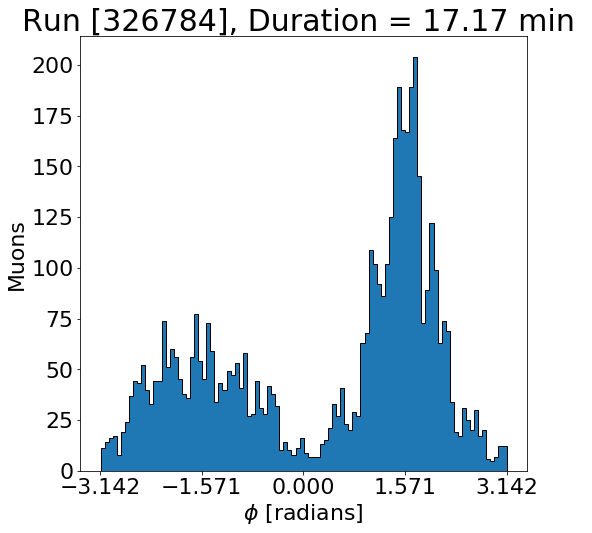

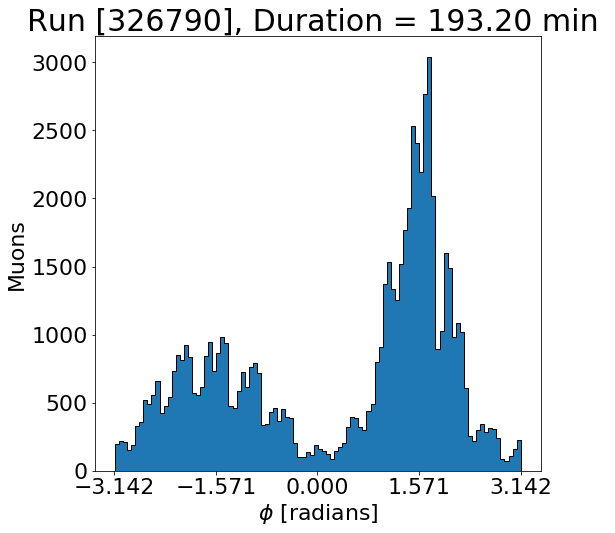

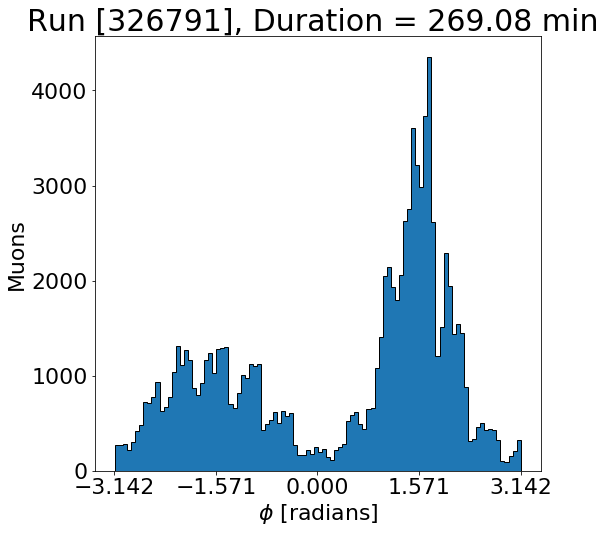

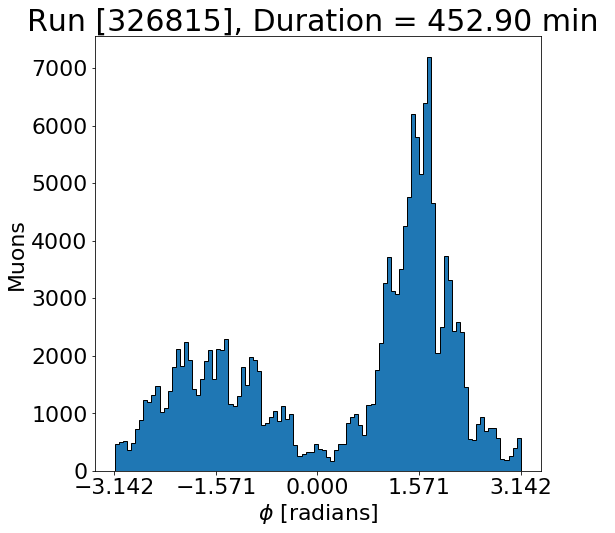

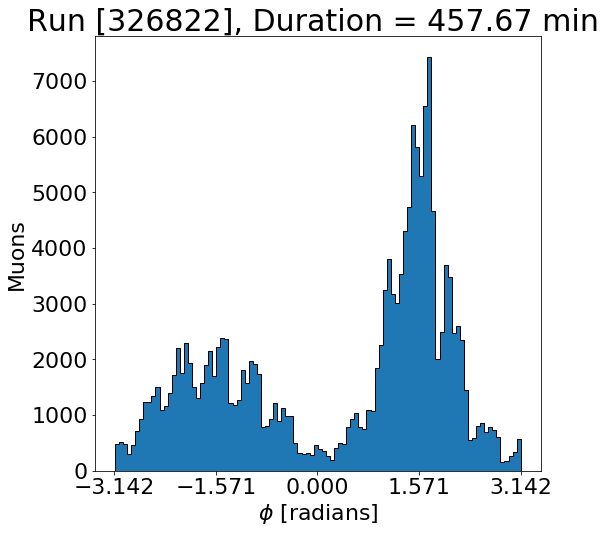

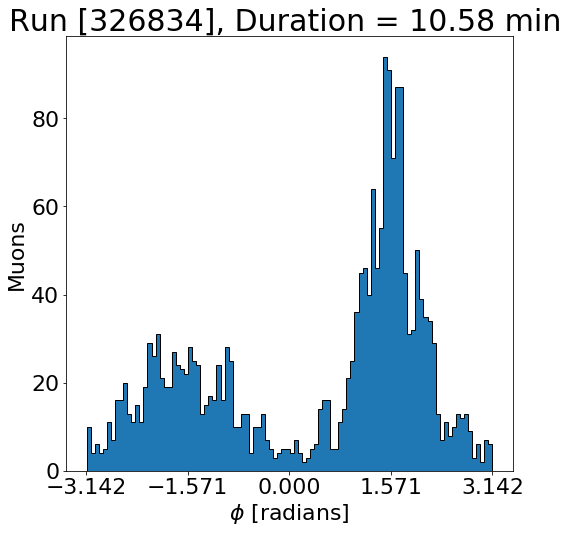

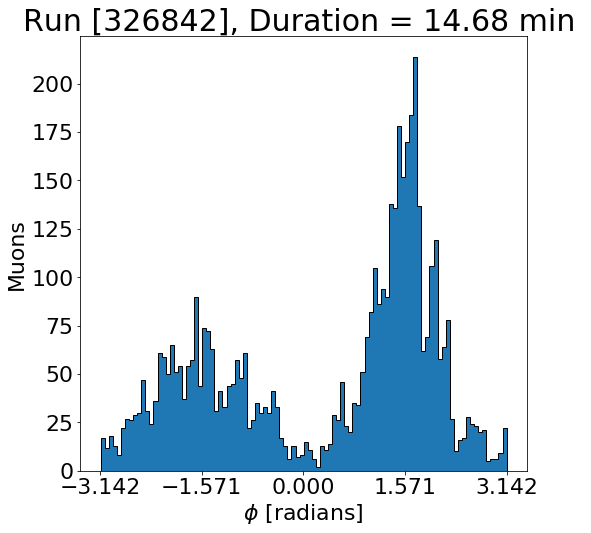

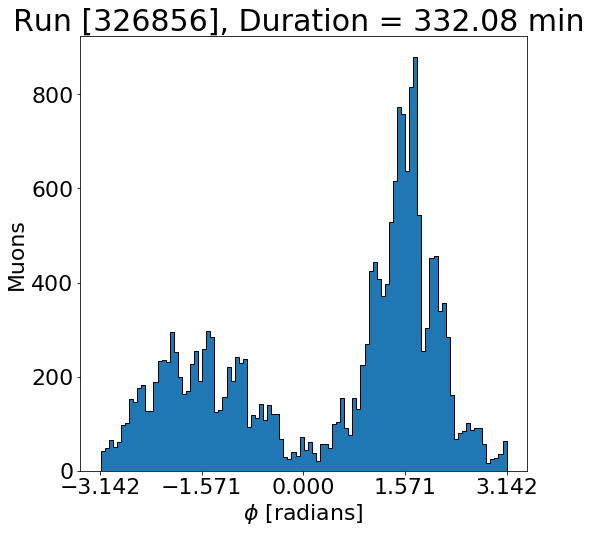

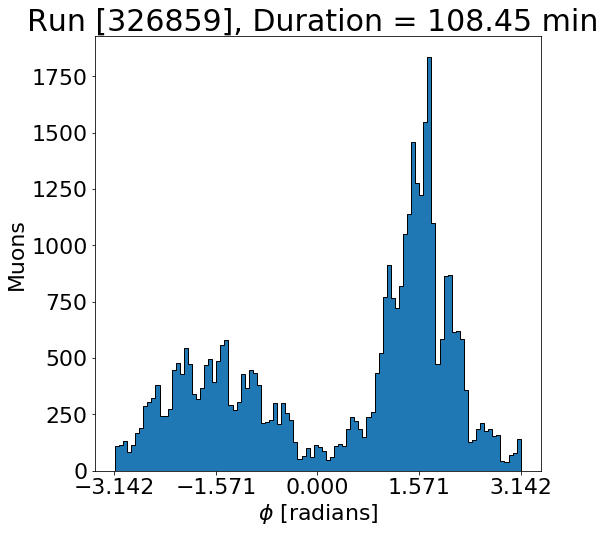

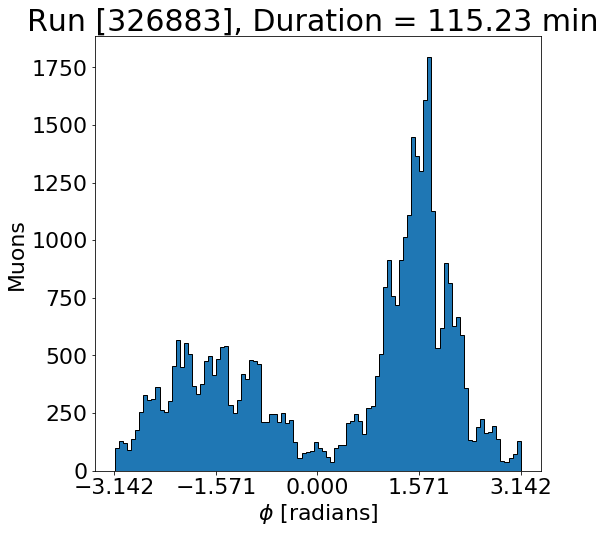

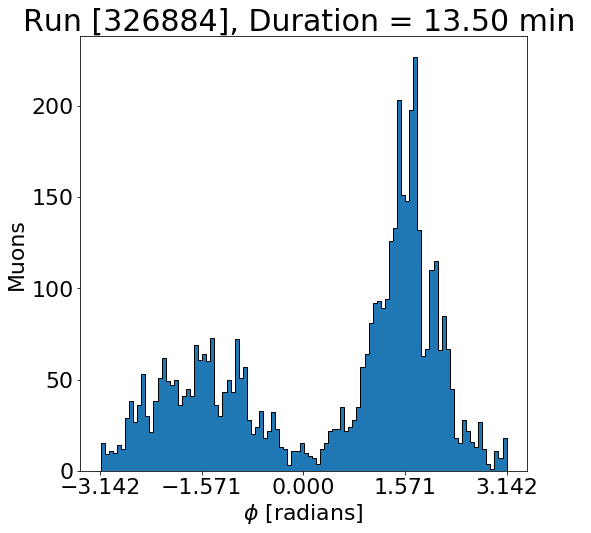

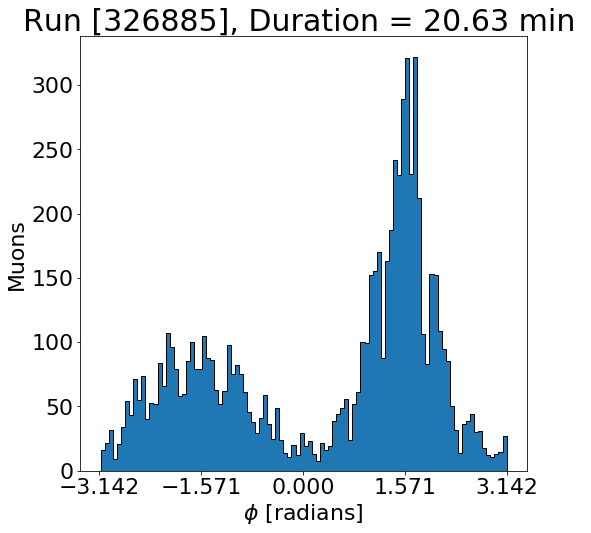

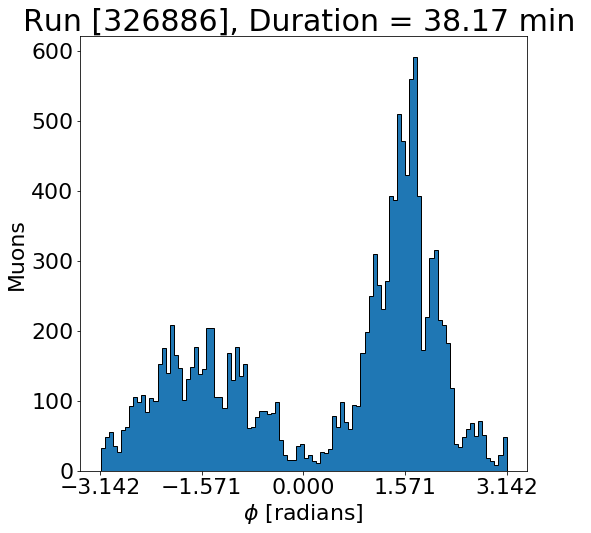

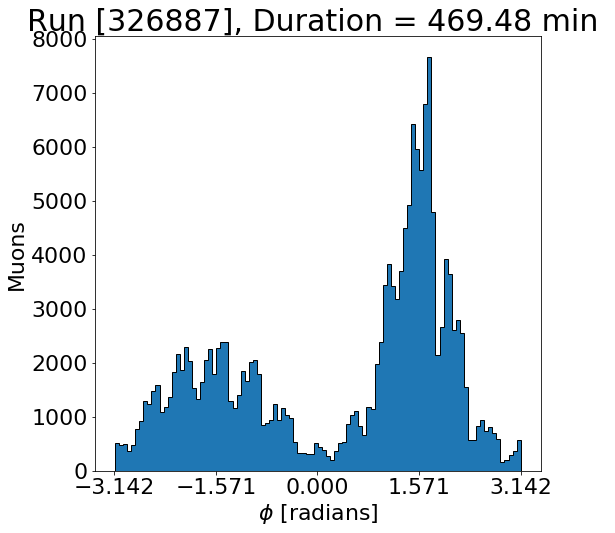

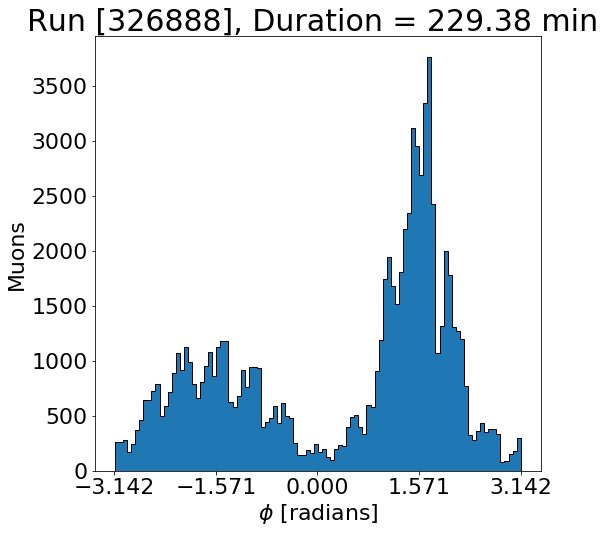

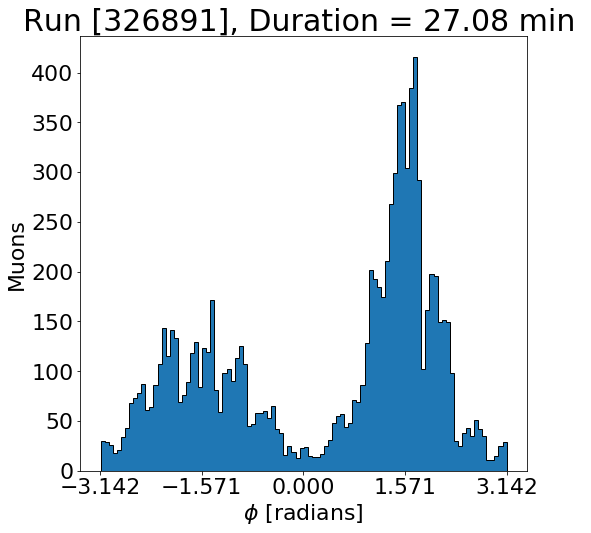

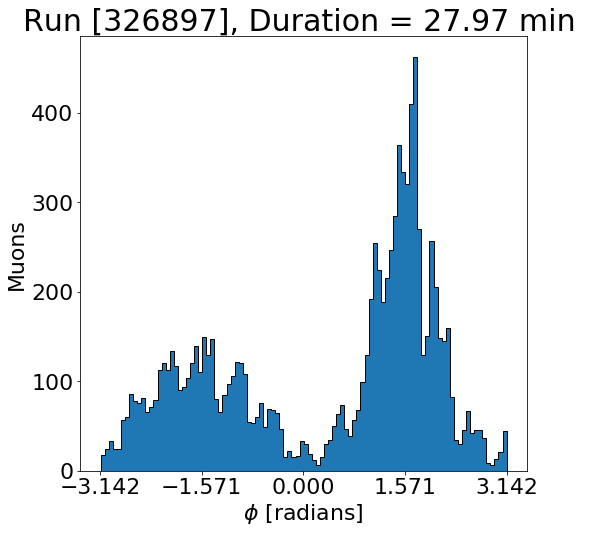

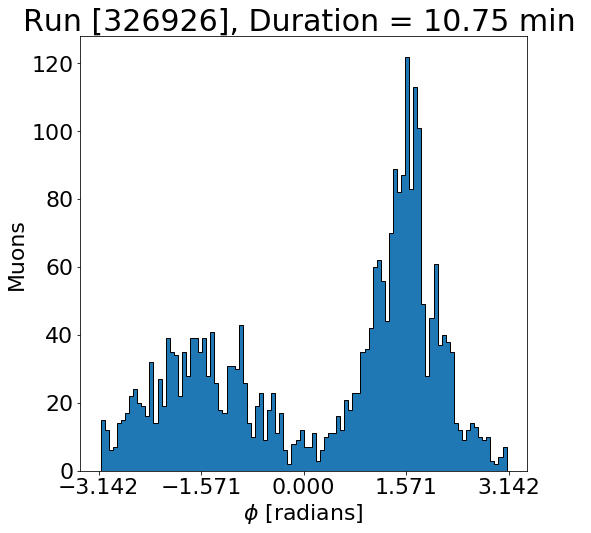

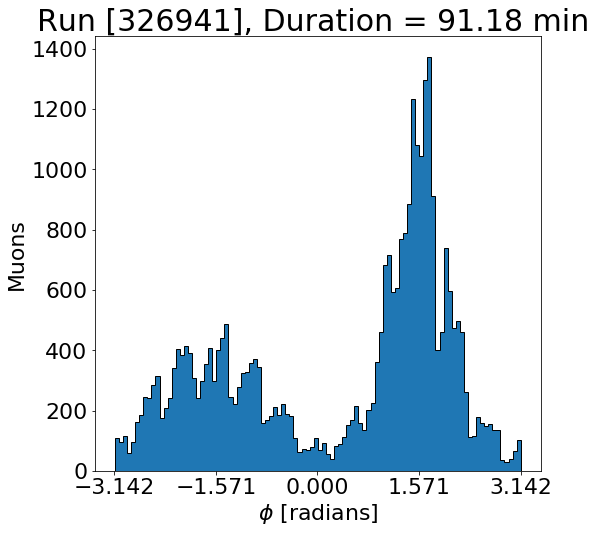

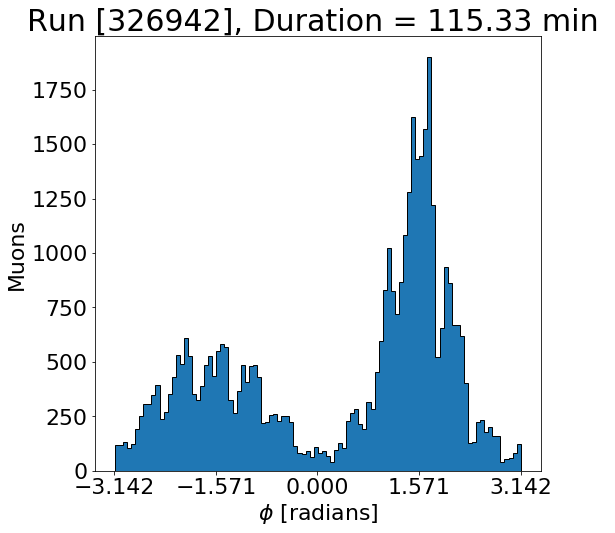

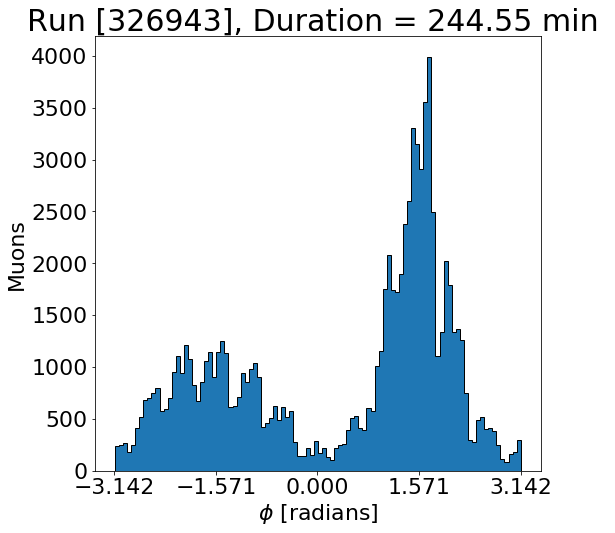

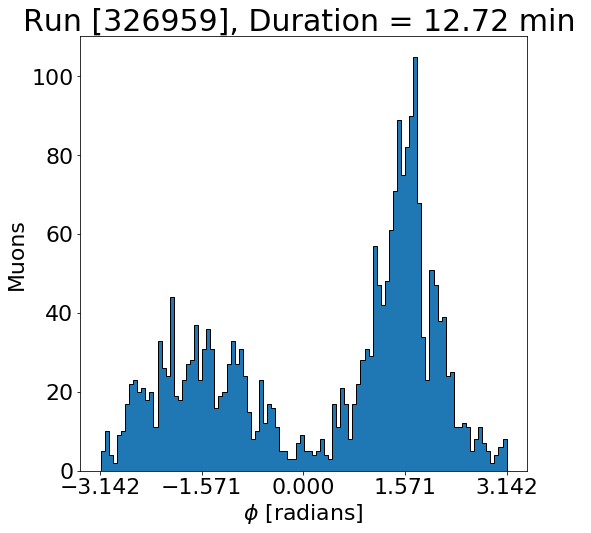

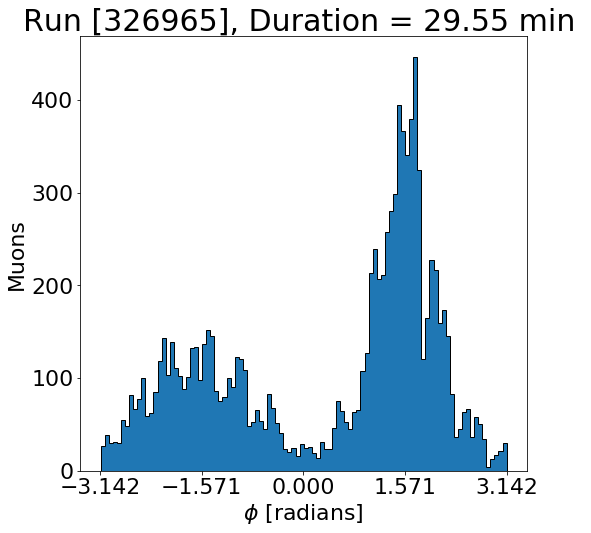

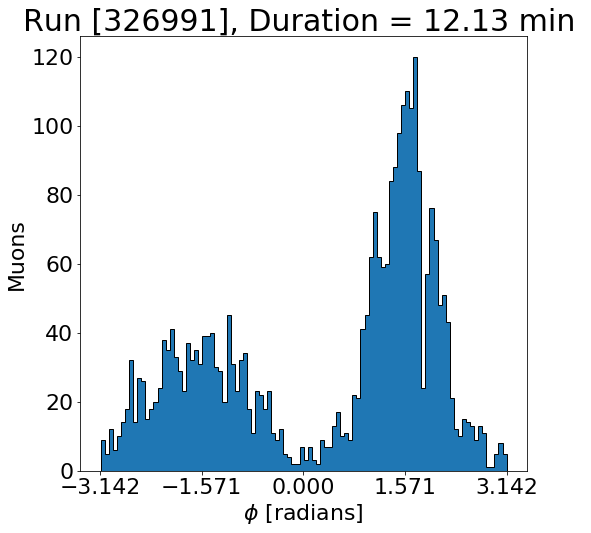

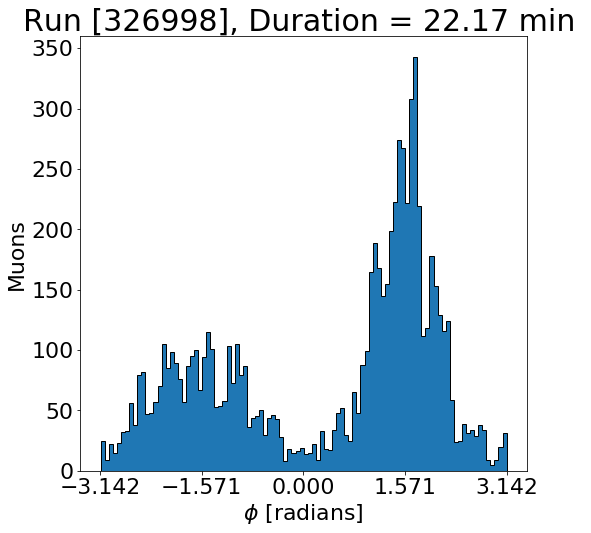

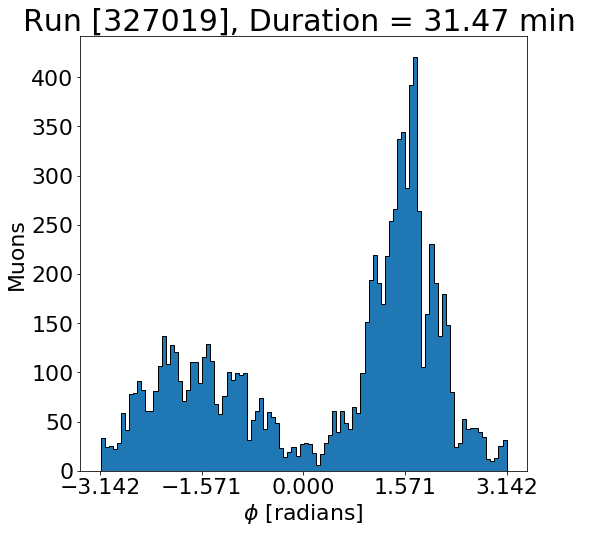

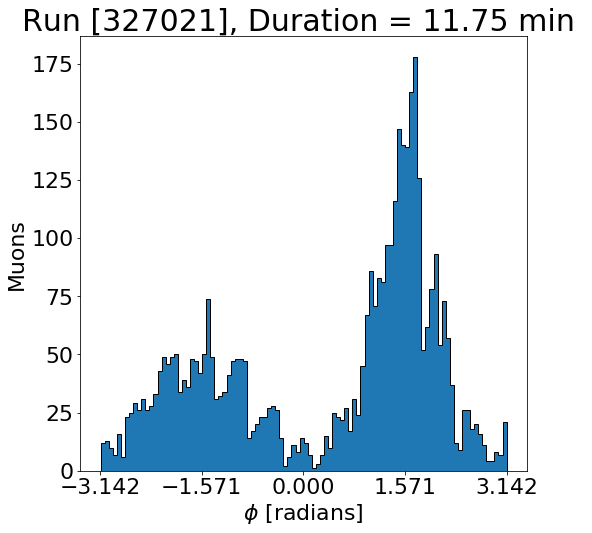

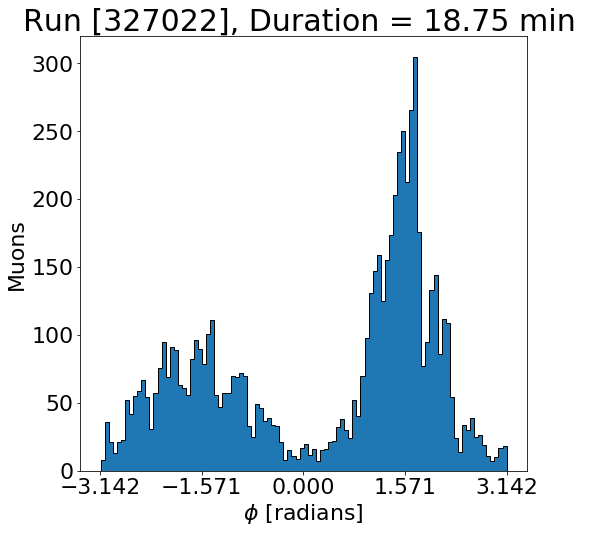

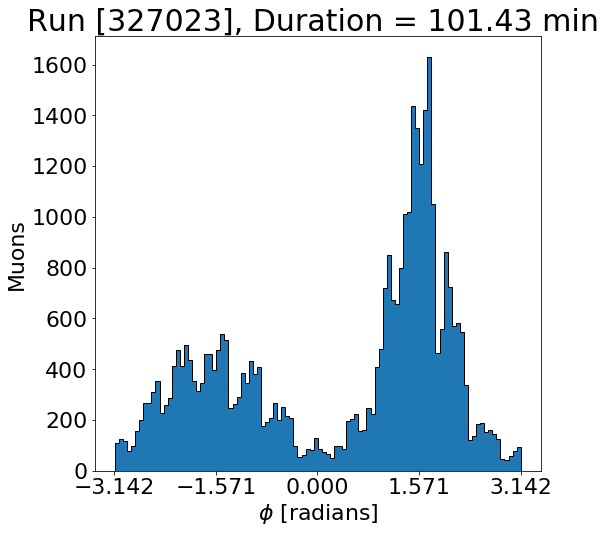

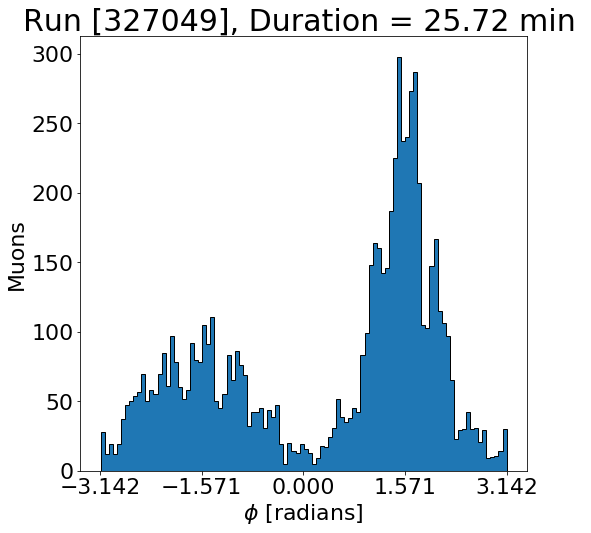

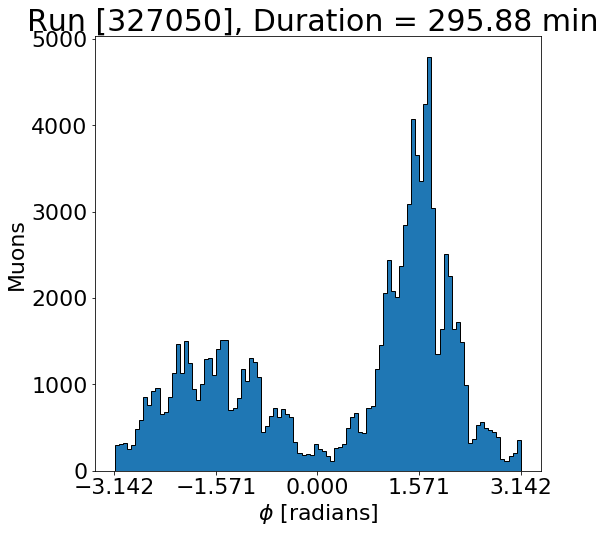

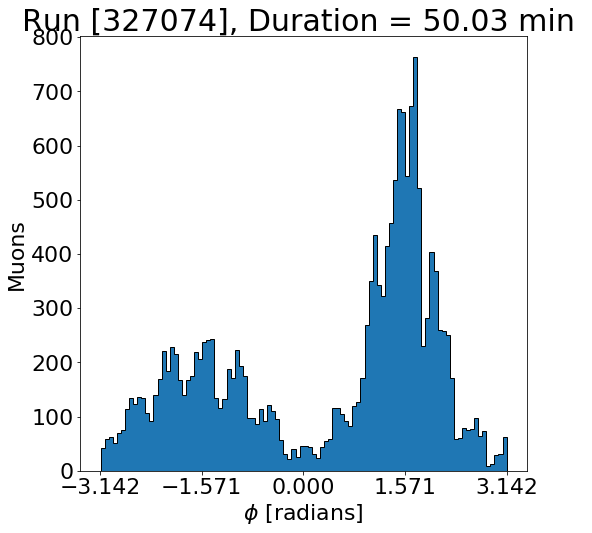

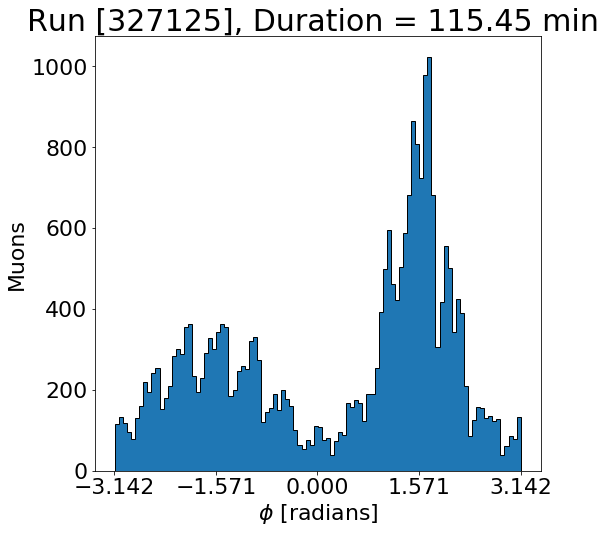

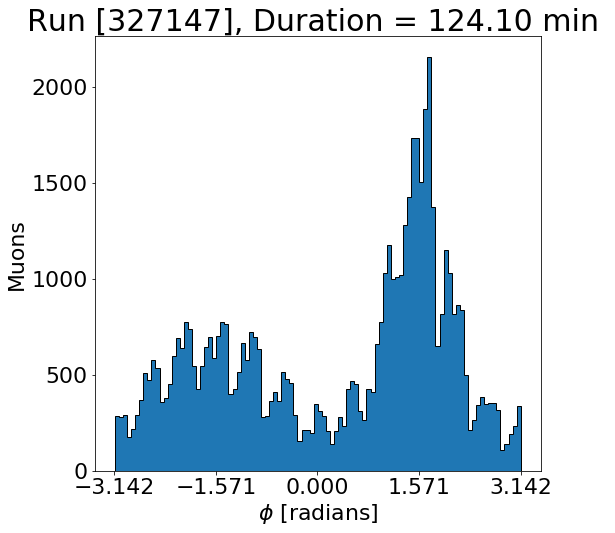

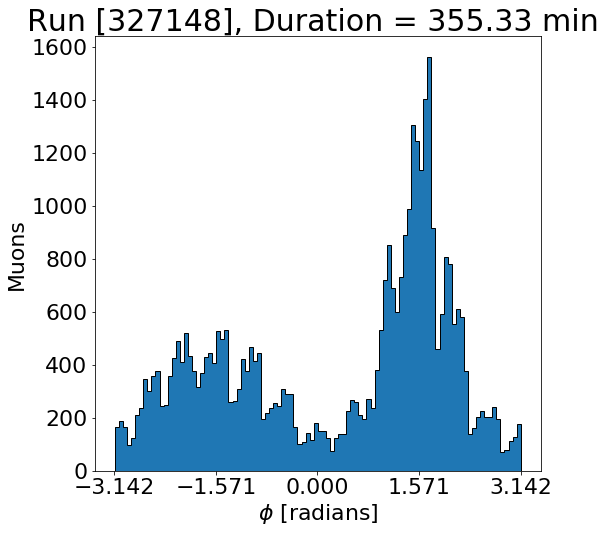

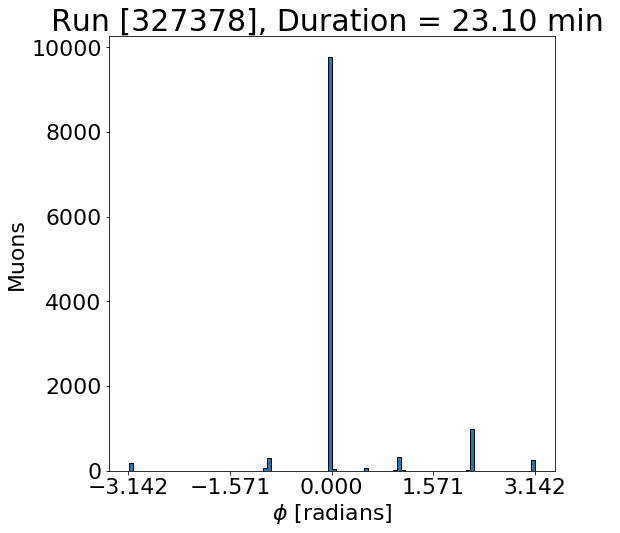

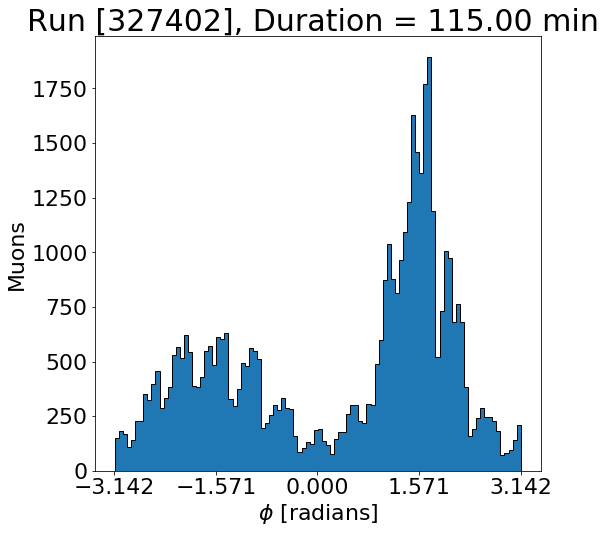

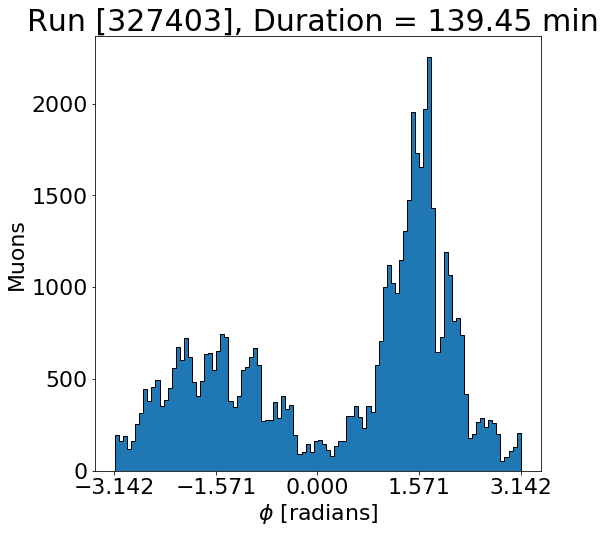

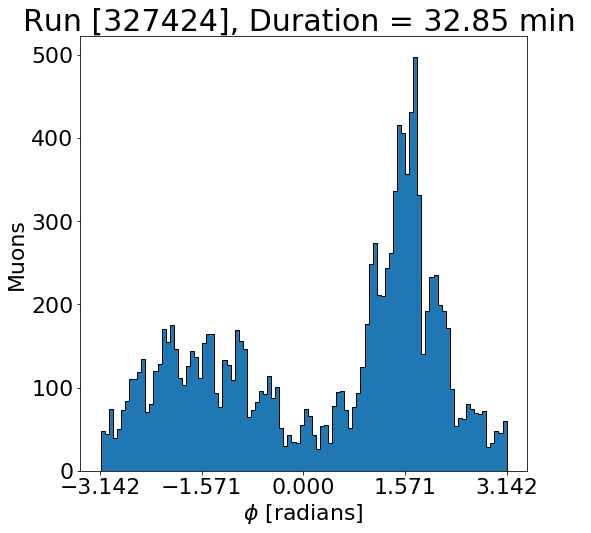

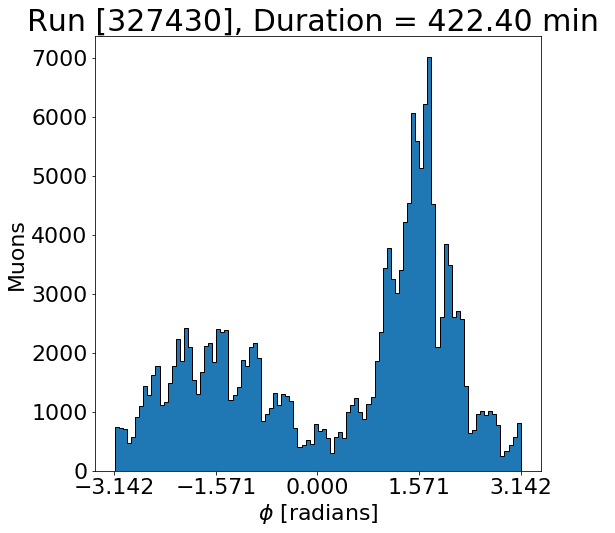

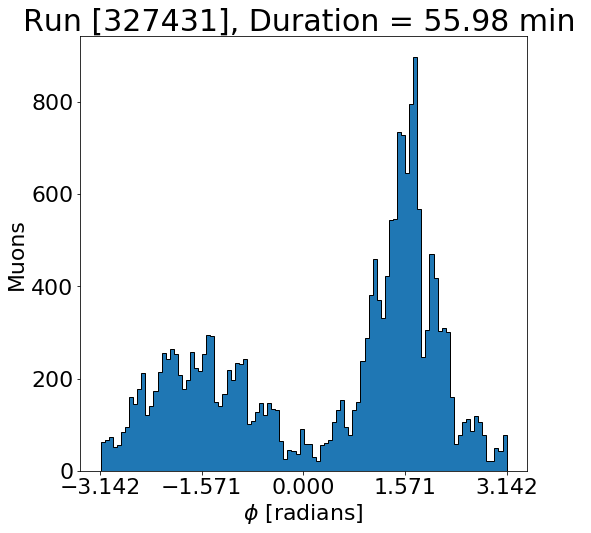

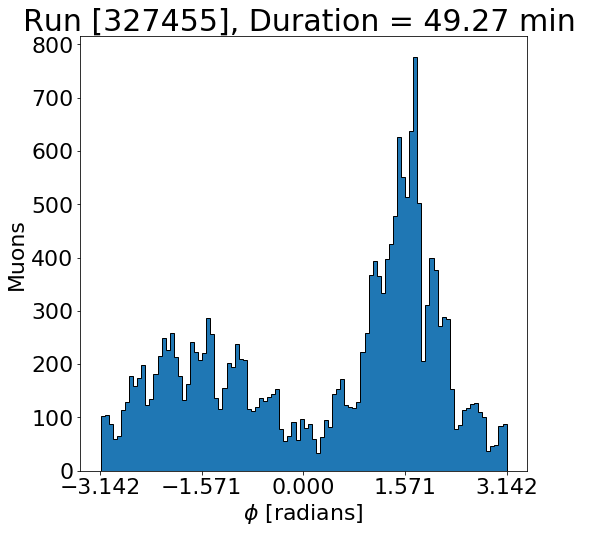

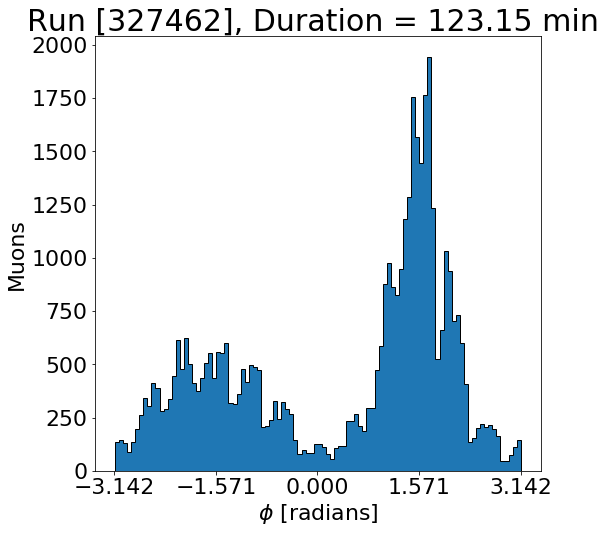

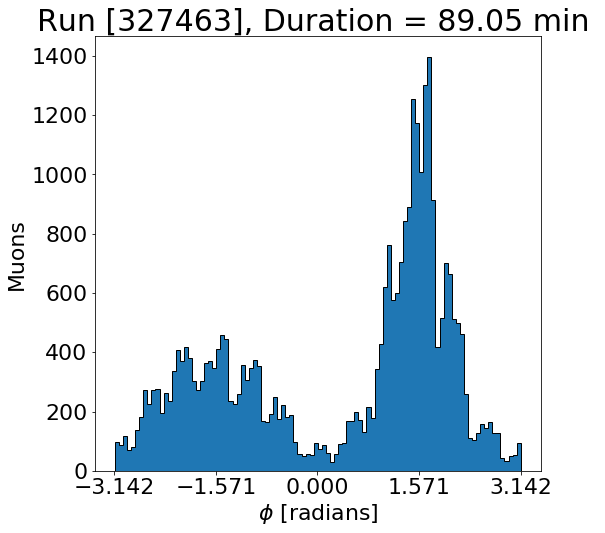

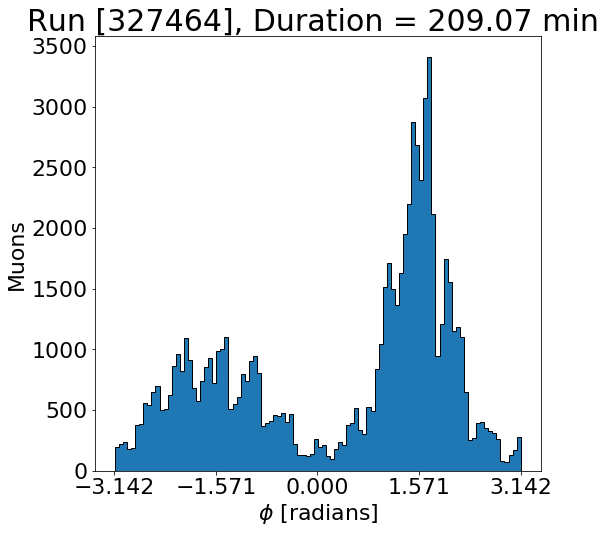

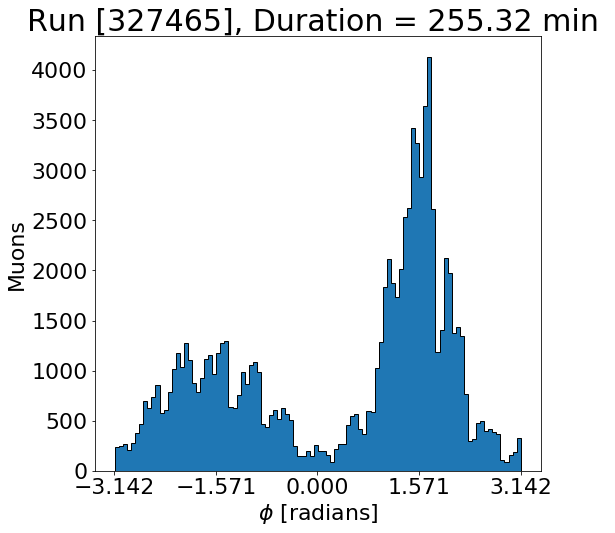

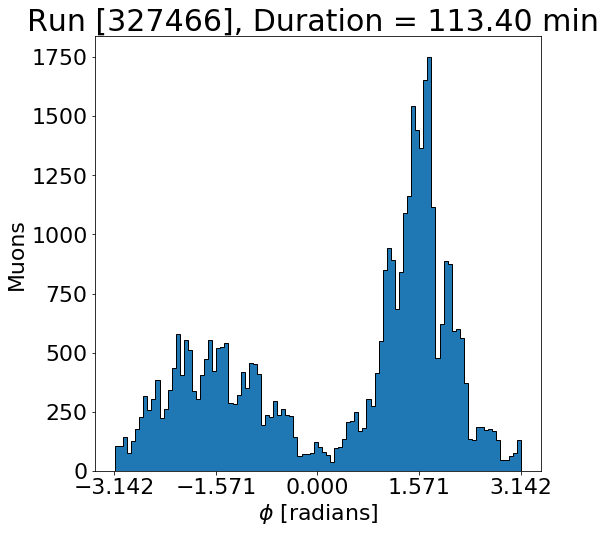

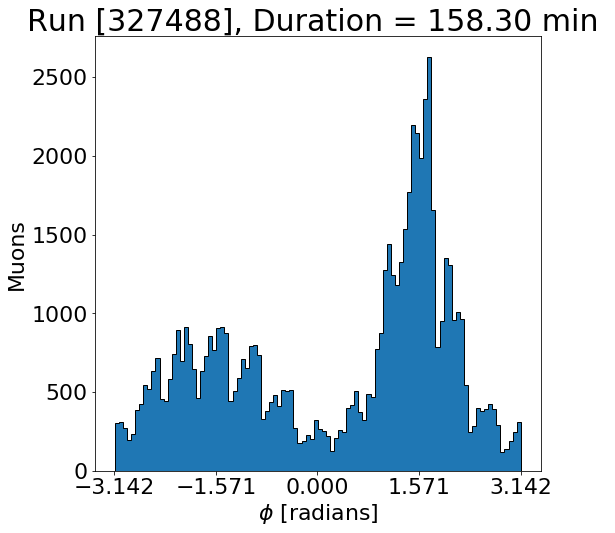

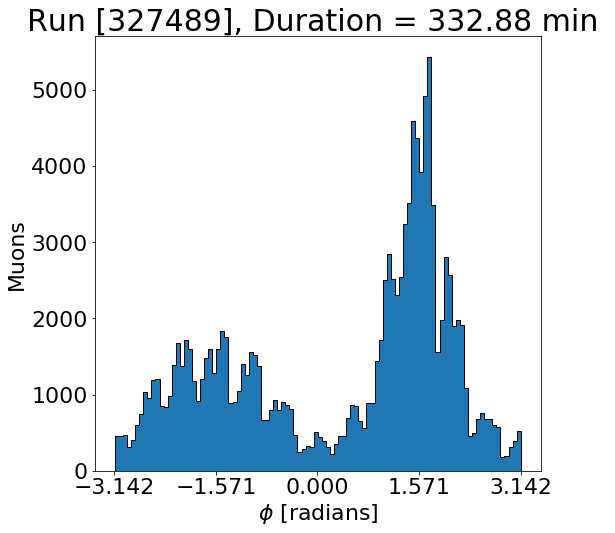

In [21]:
for run in runs:
    run.plotPhi(bins = 100)

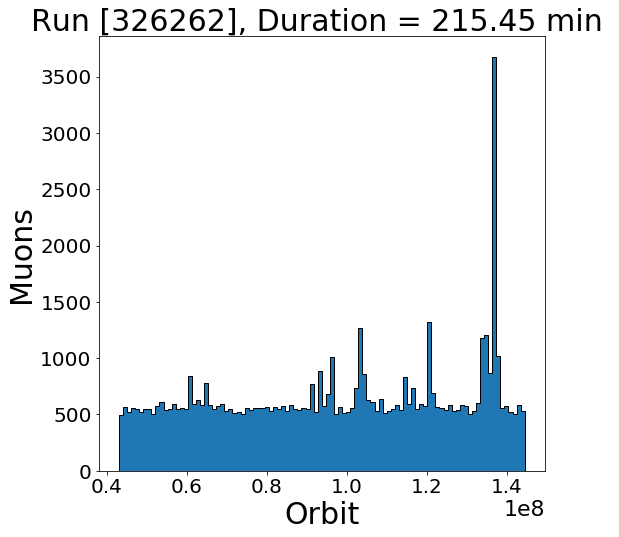

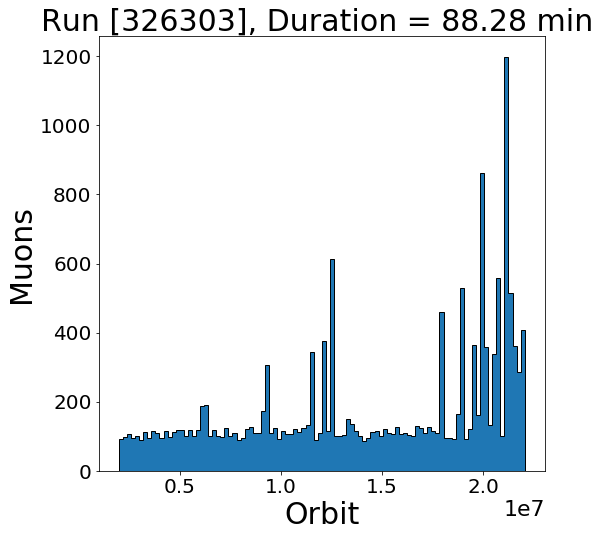

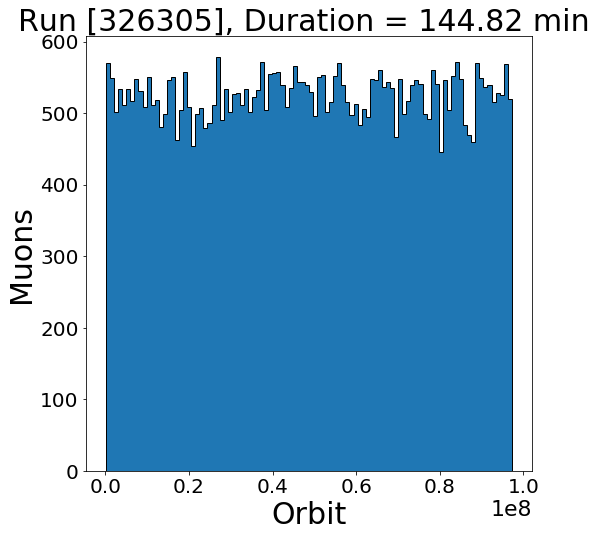

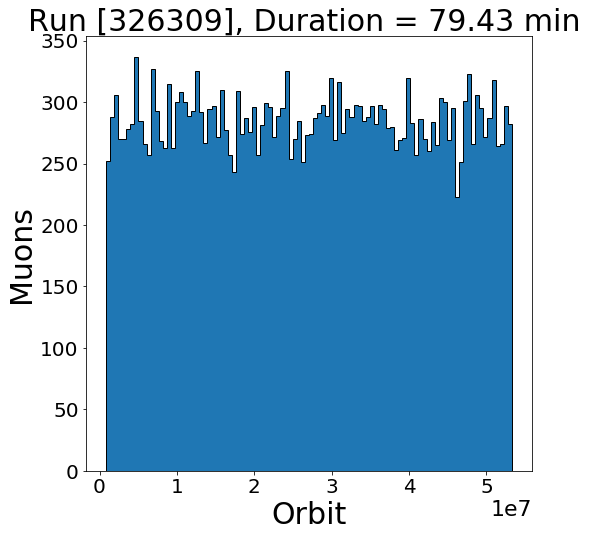

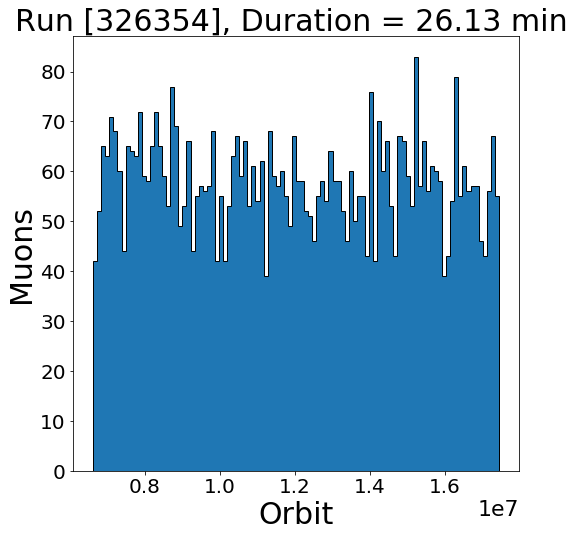

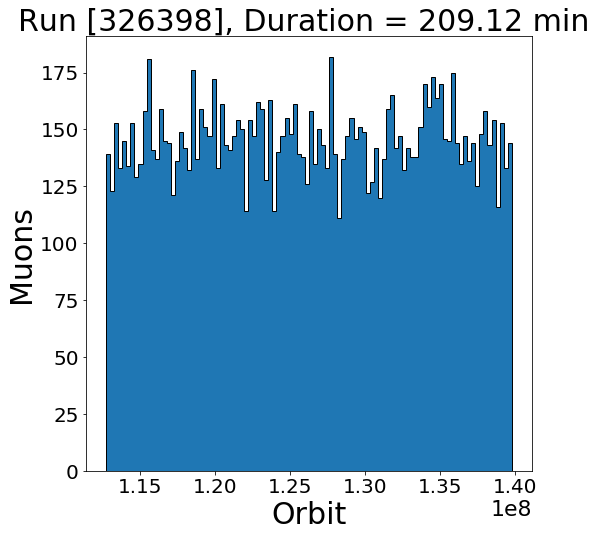

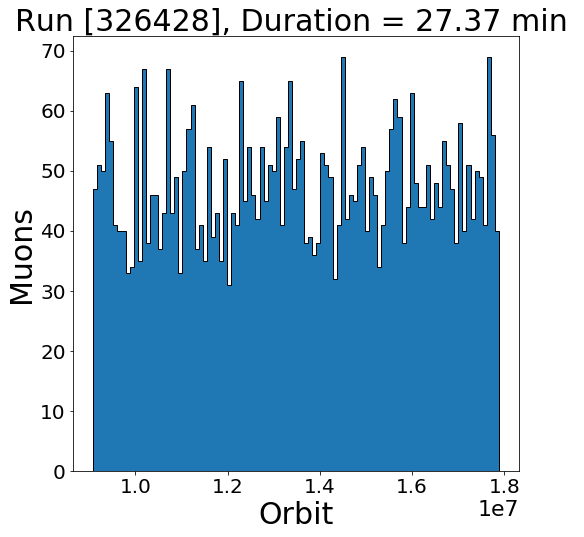

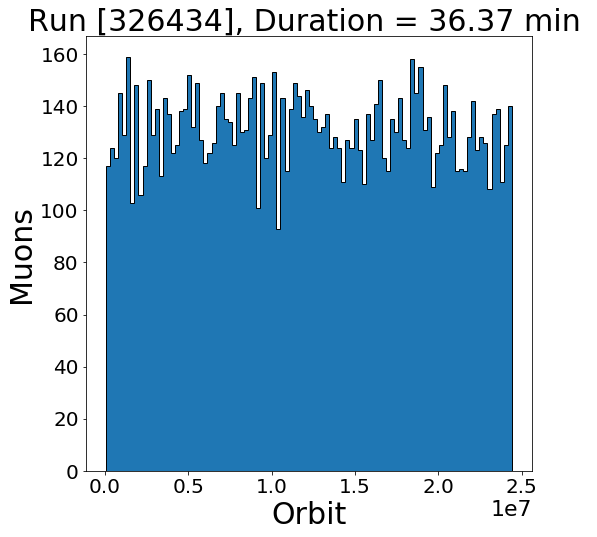

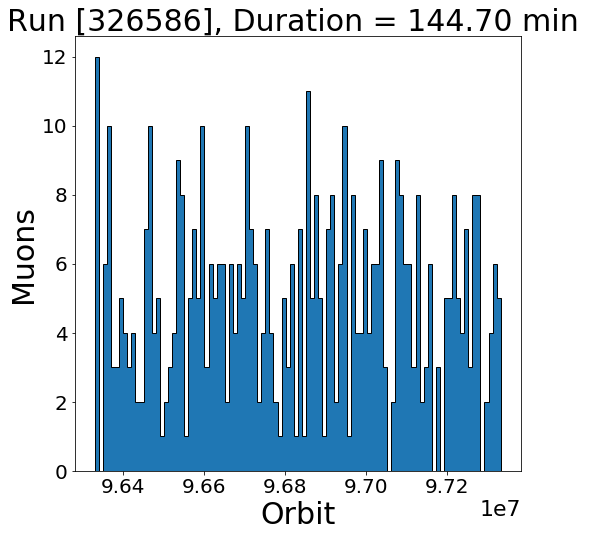

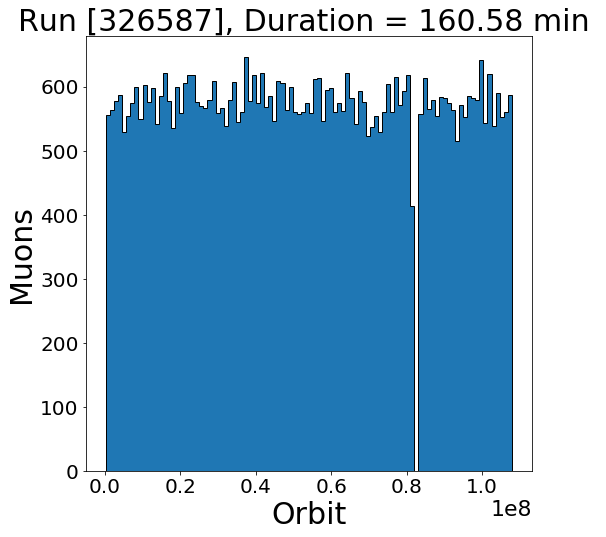

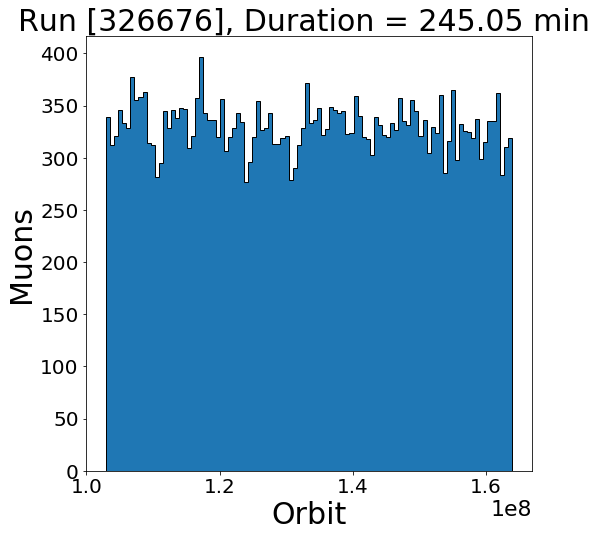

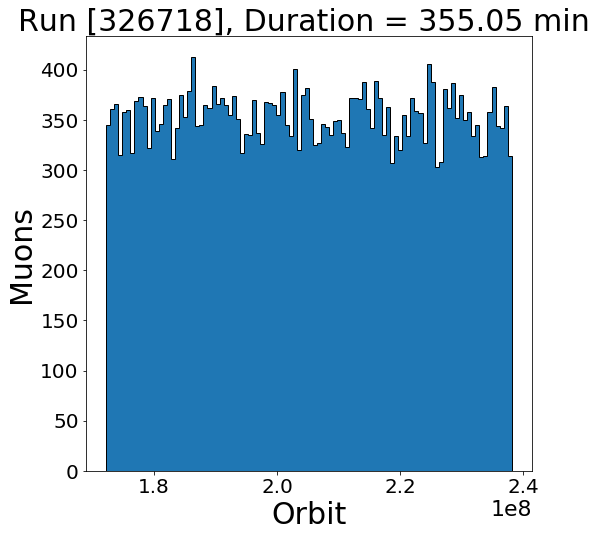

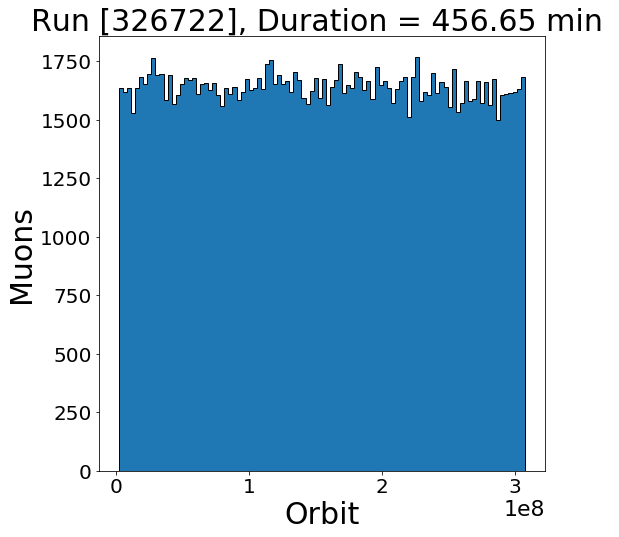

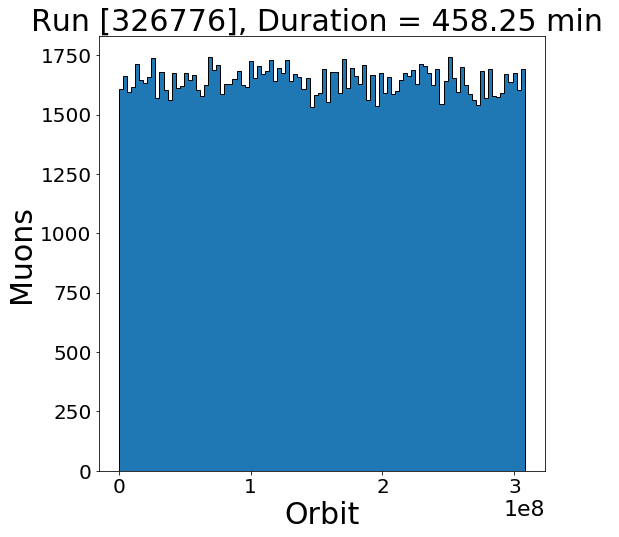

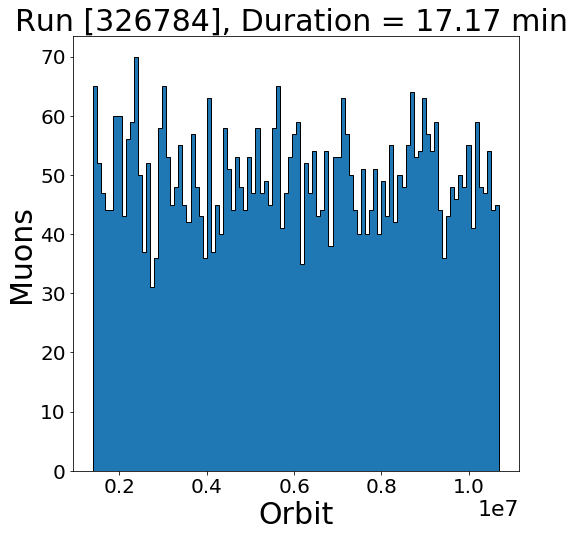

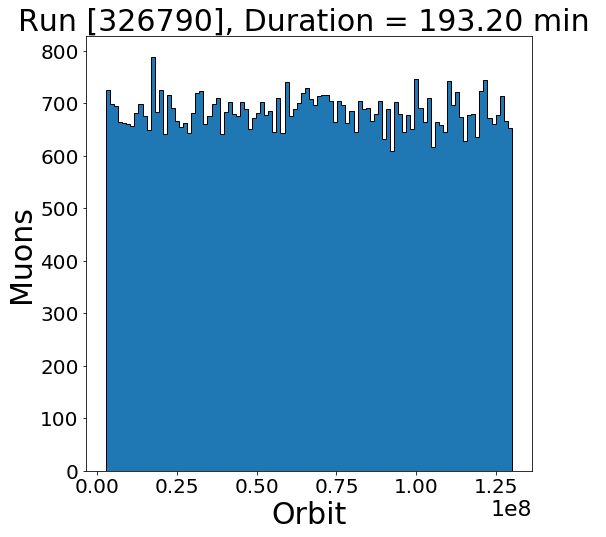

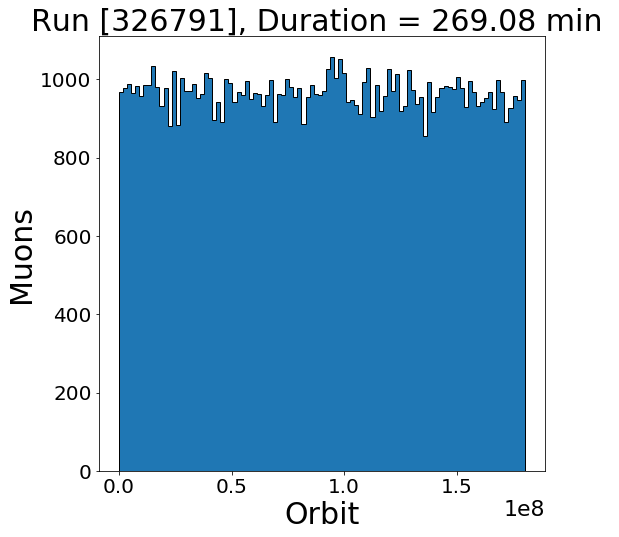

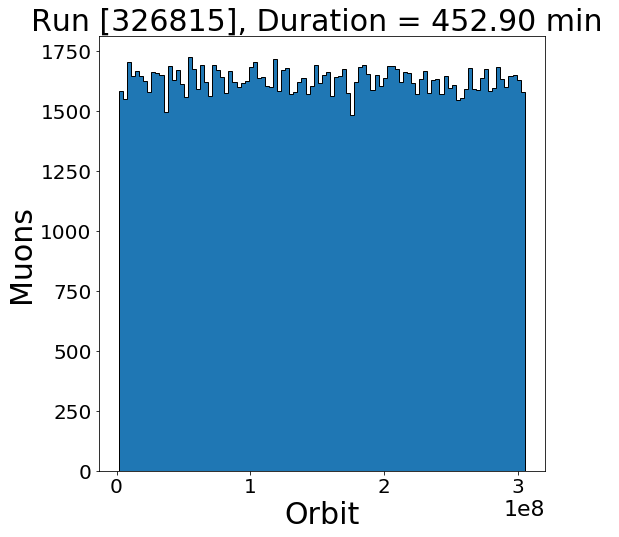

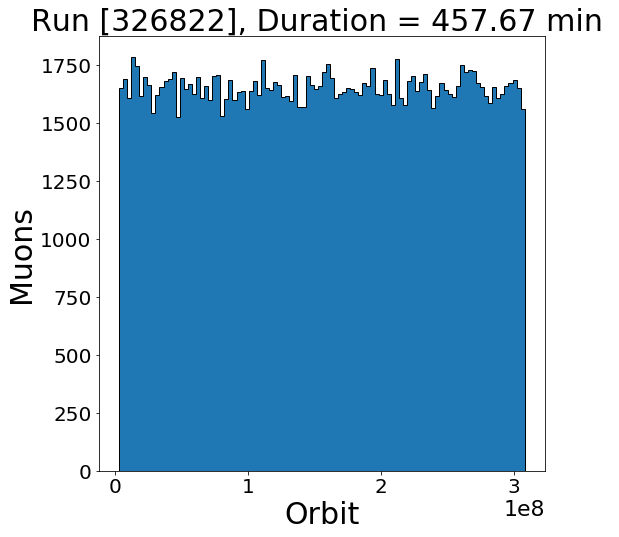

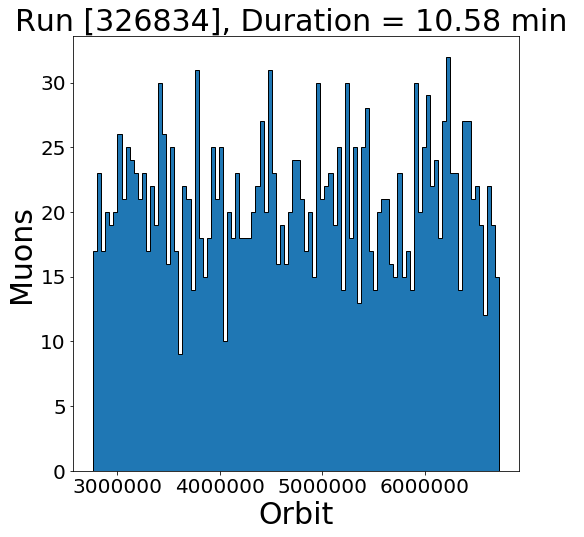

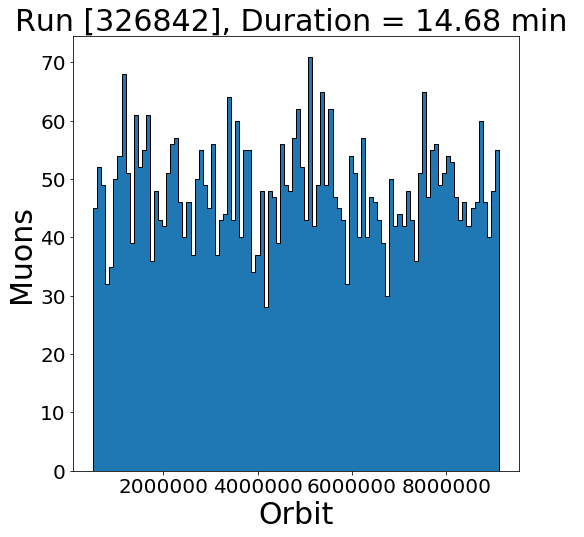

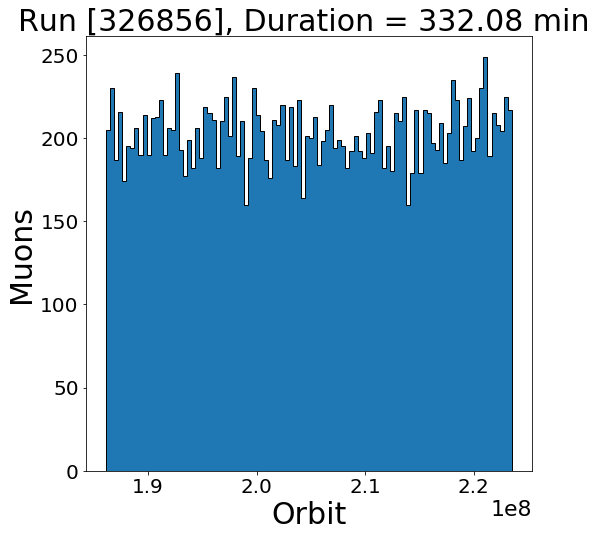

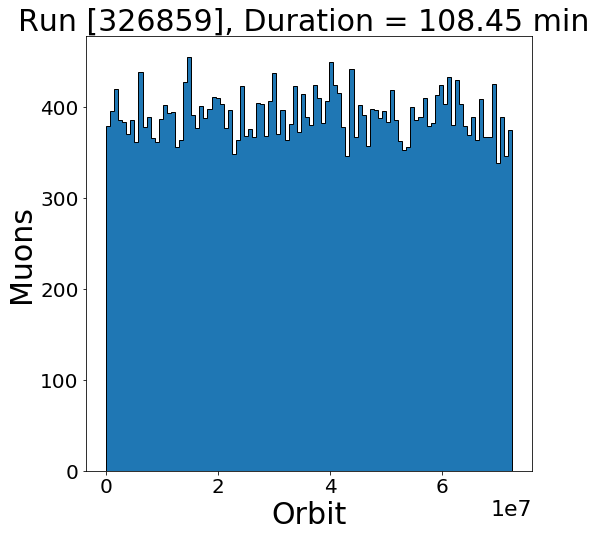

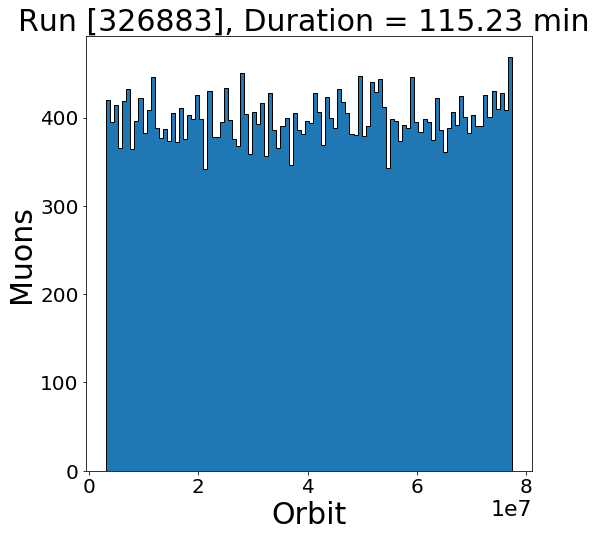

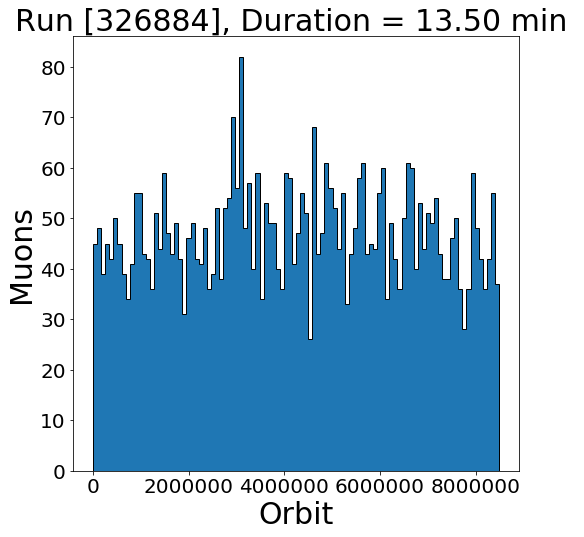

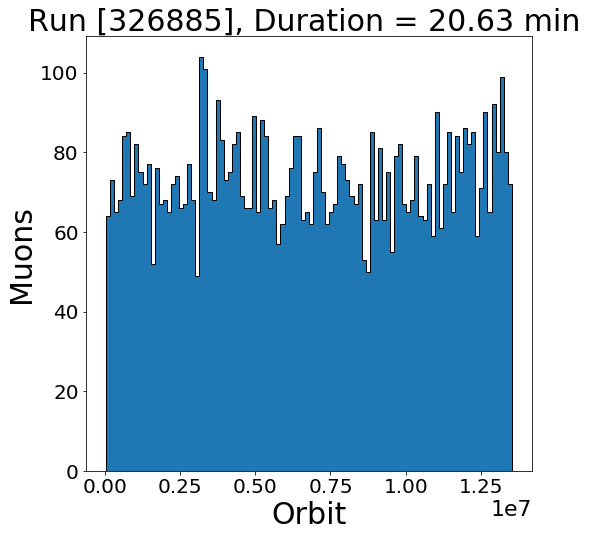

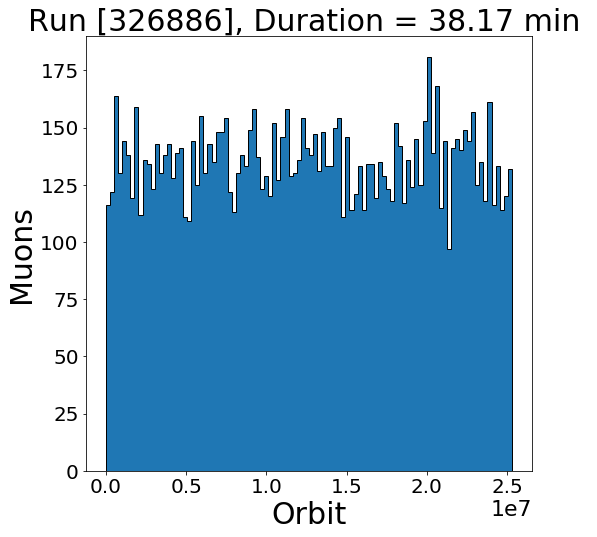

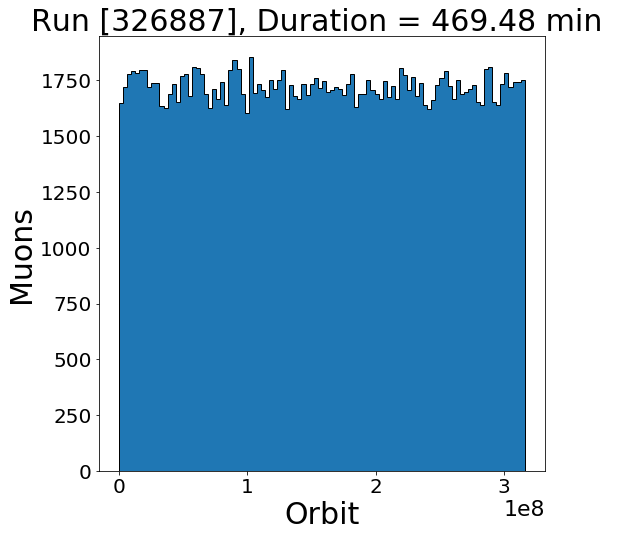

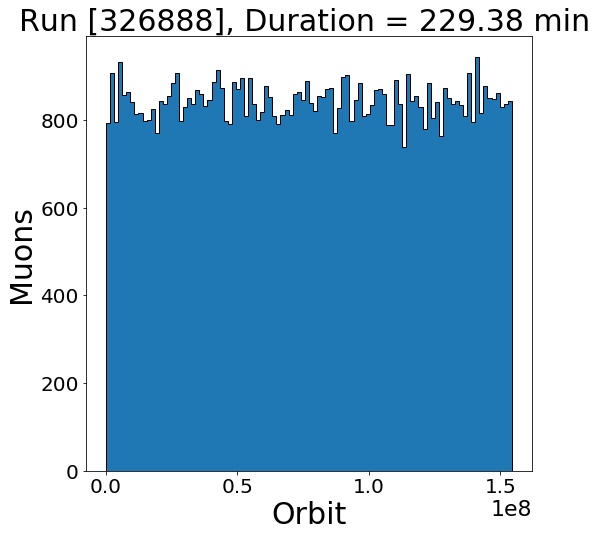

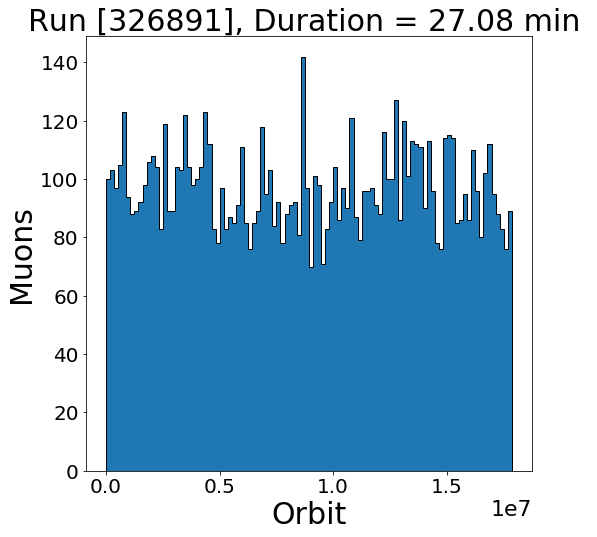

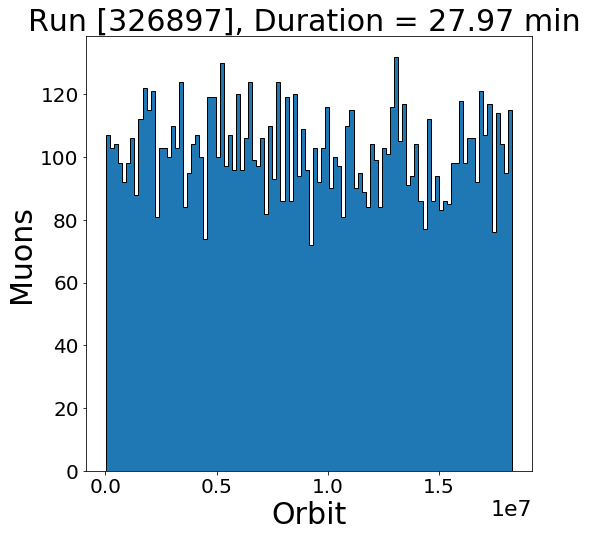

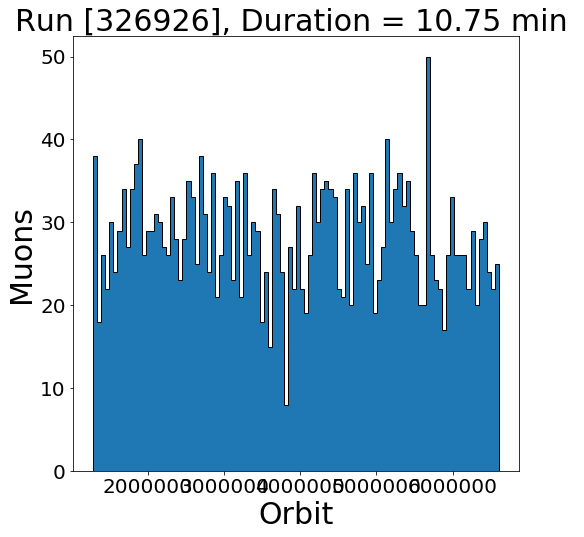

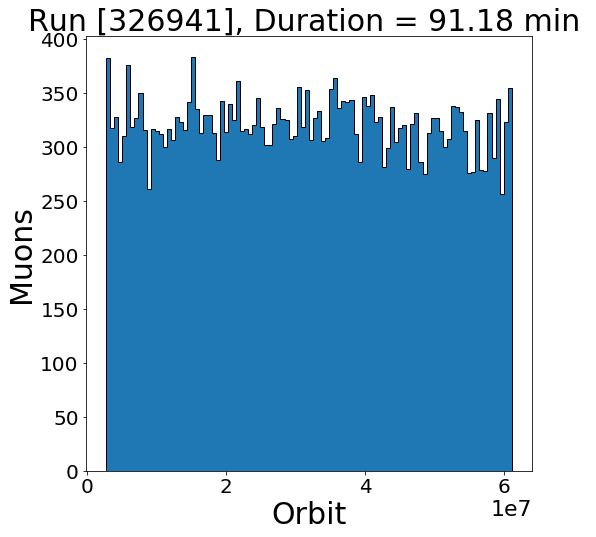

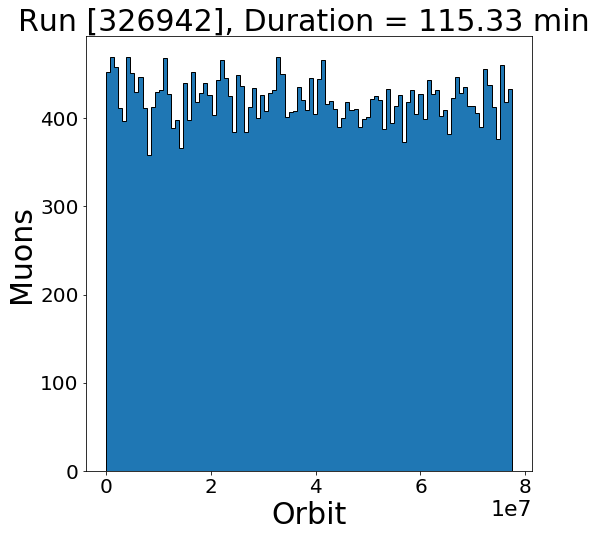

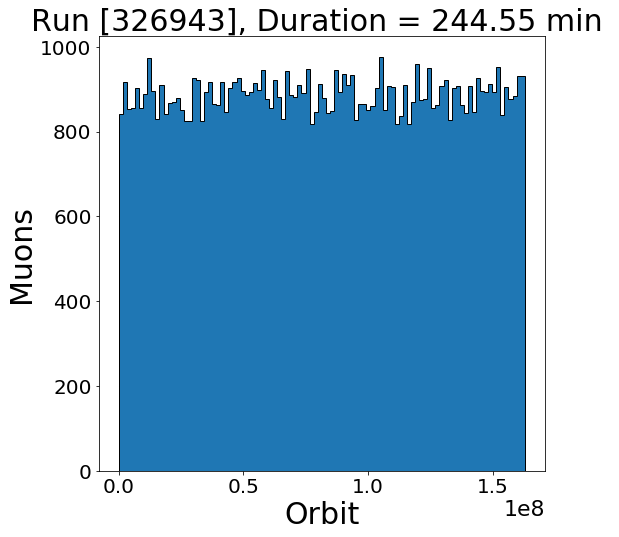

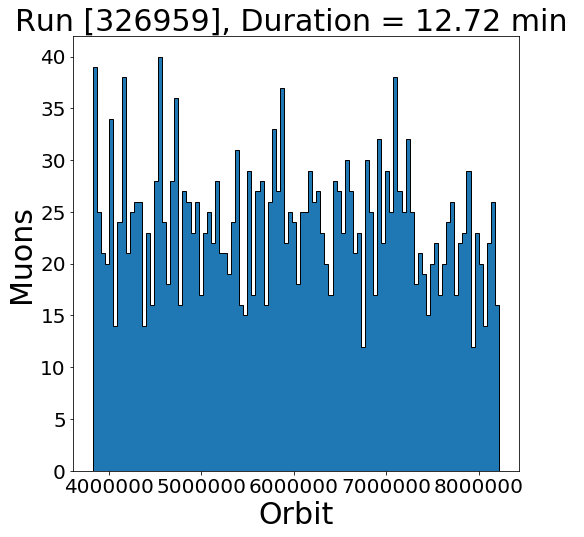

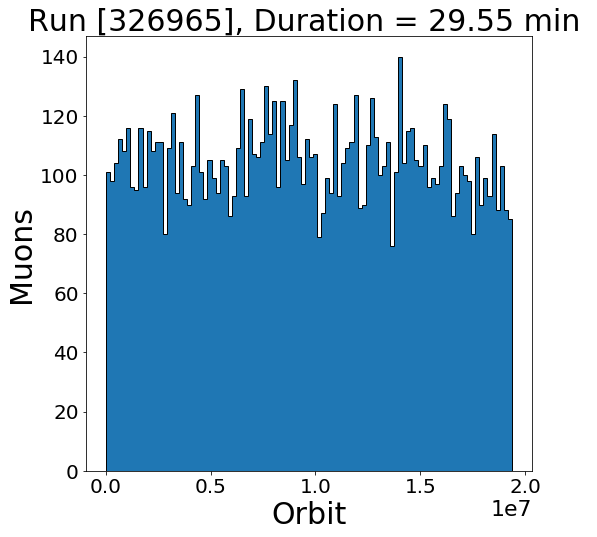

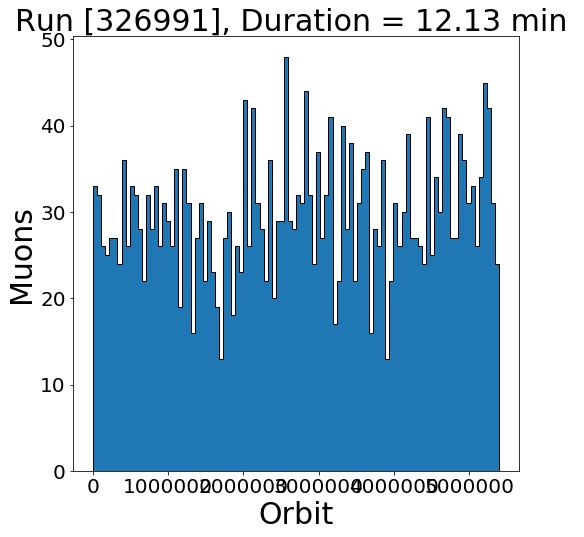

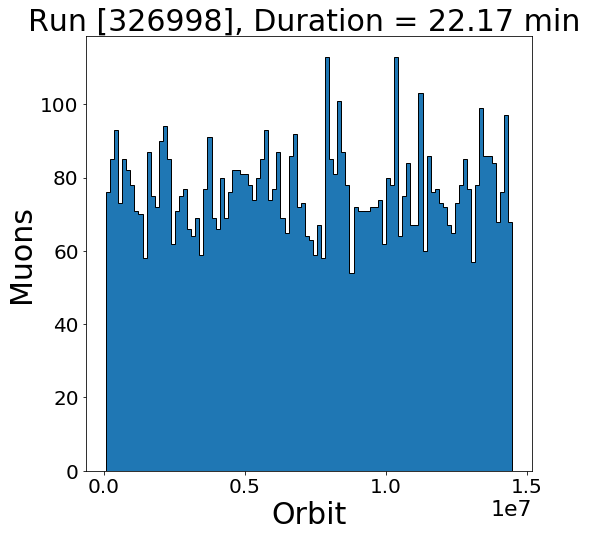

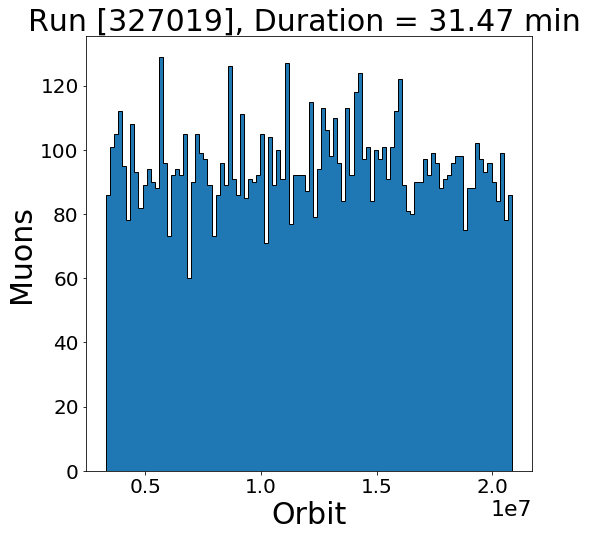

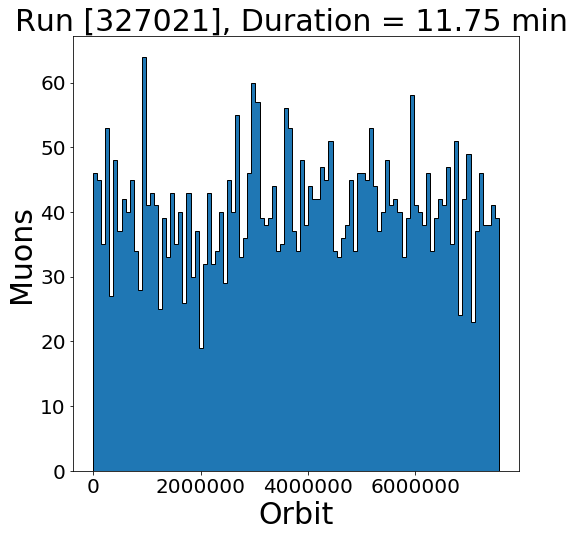

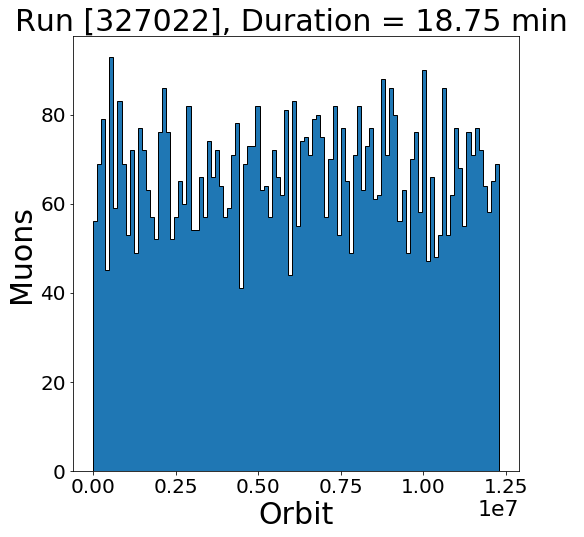

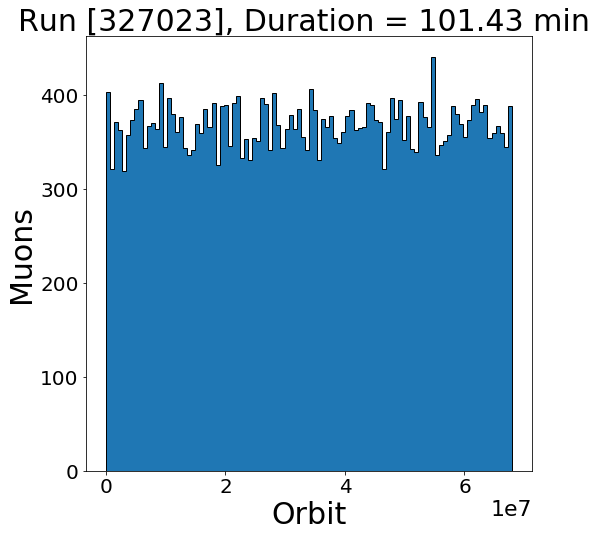

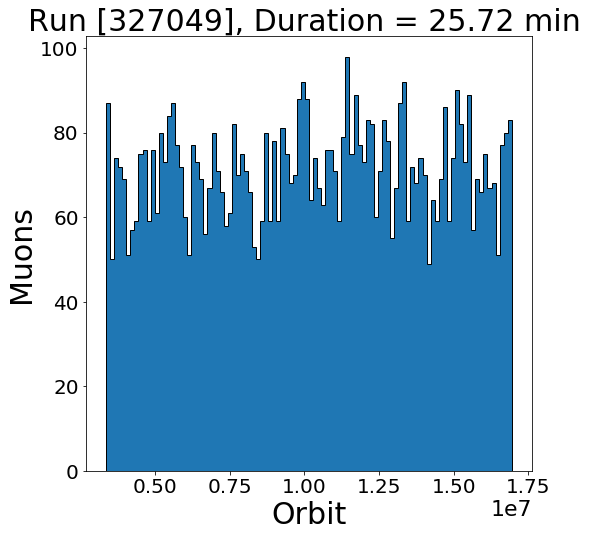

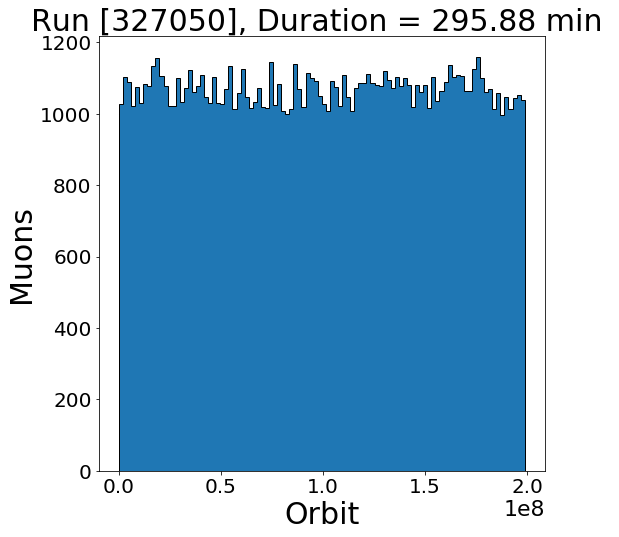

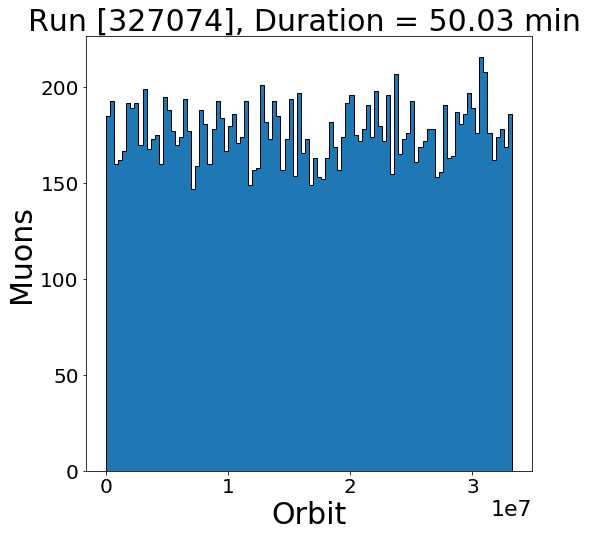

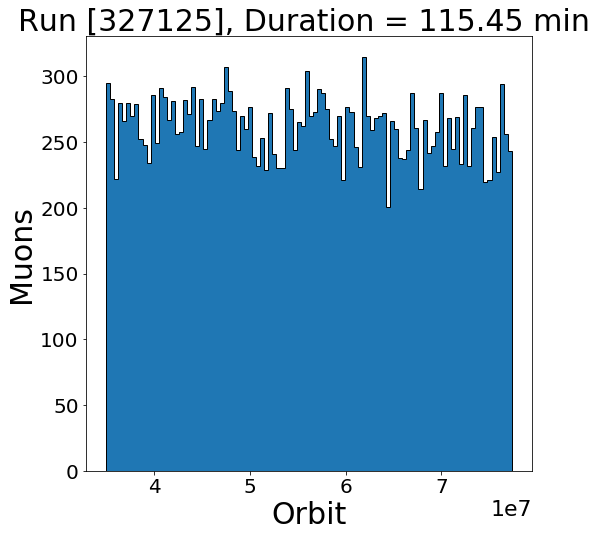

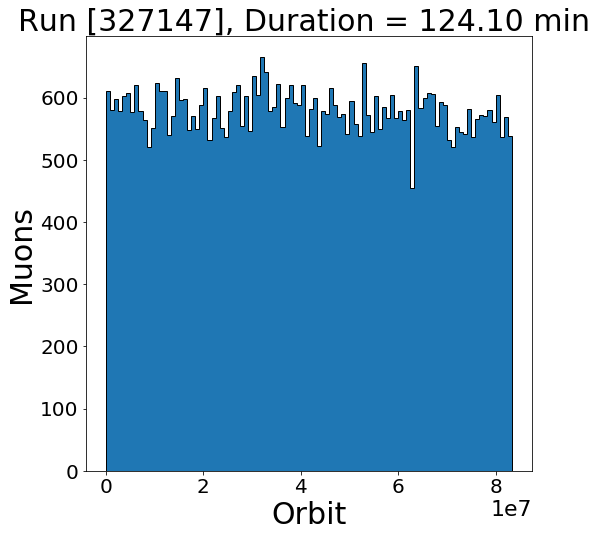

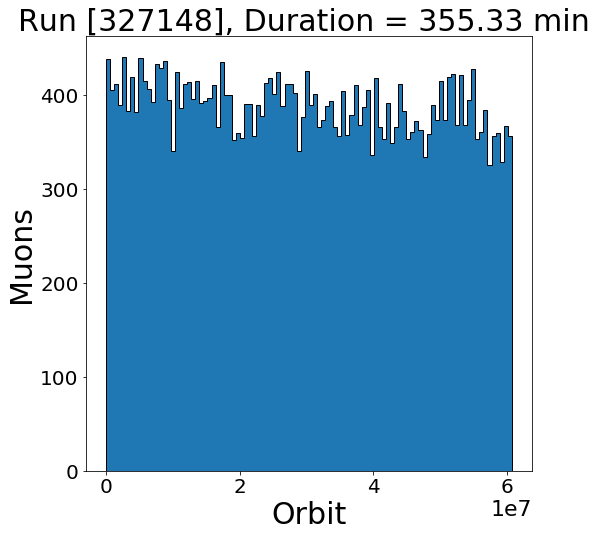

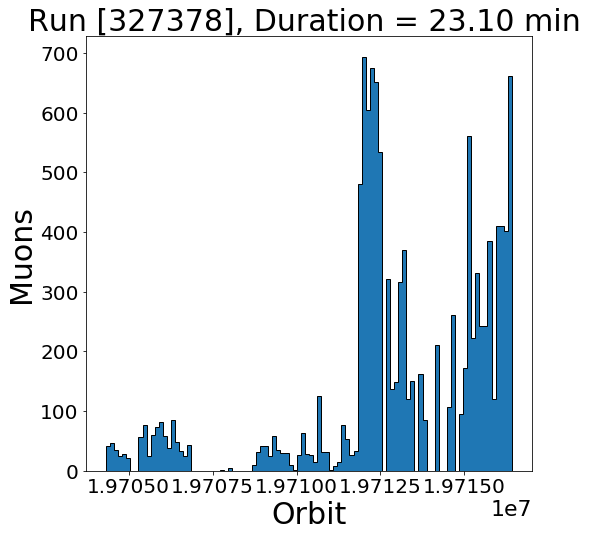

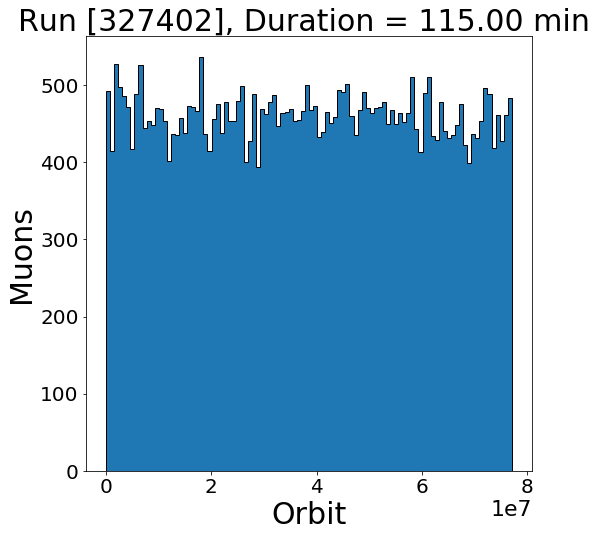

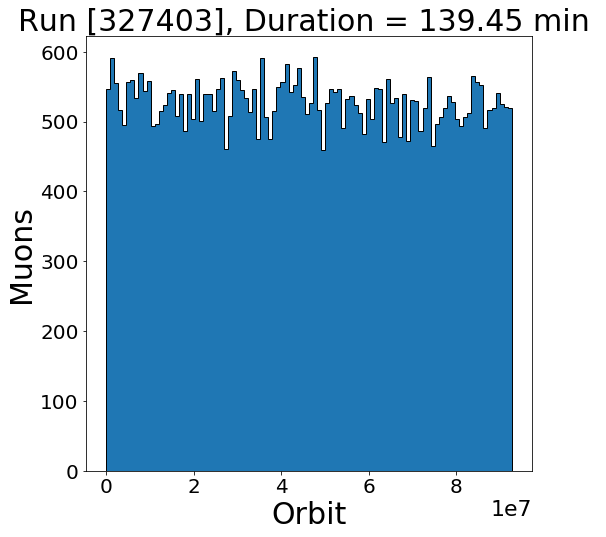

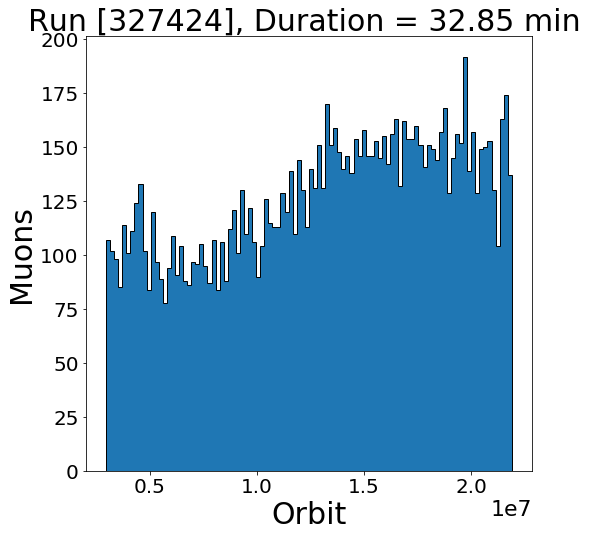

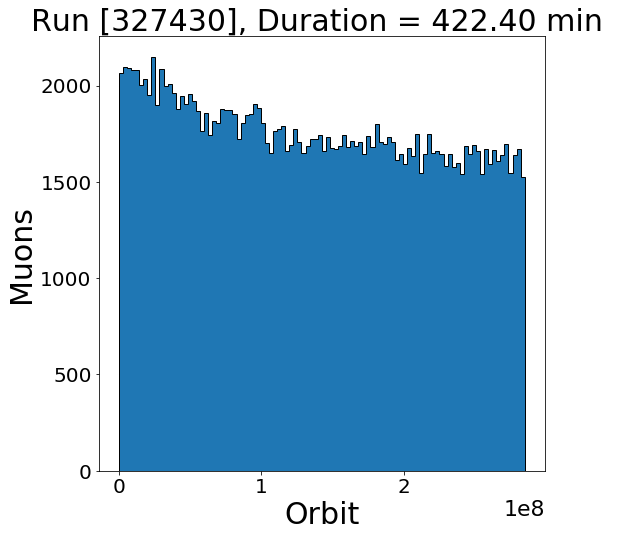

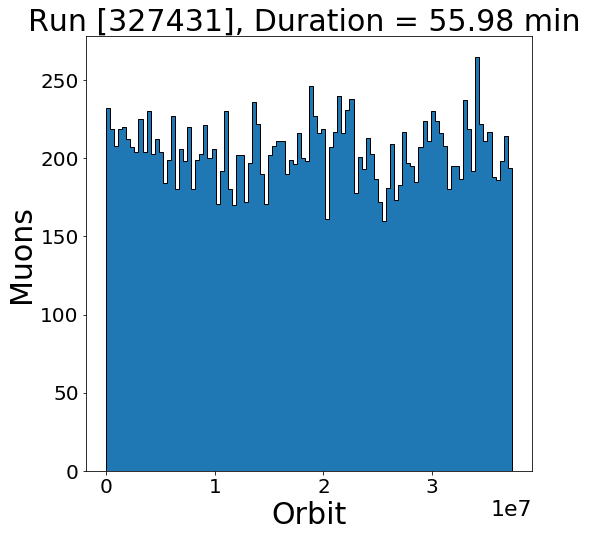

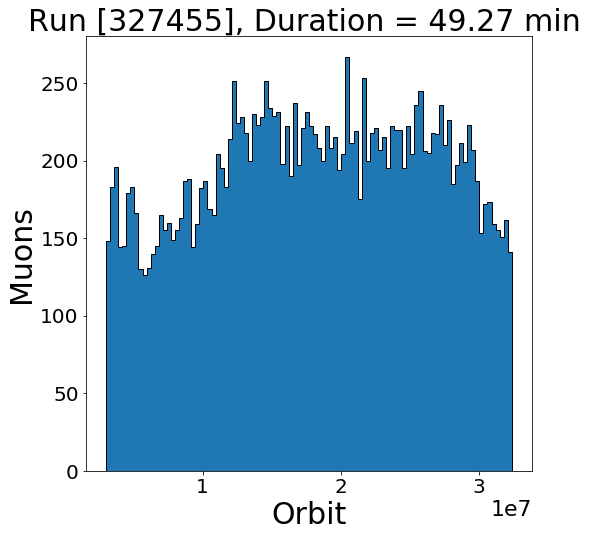

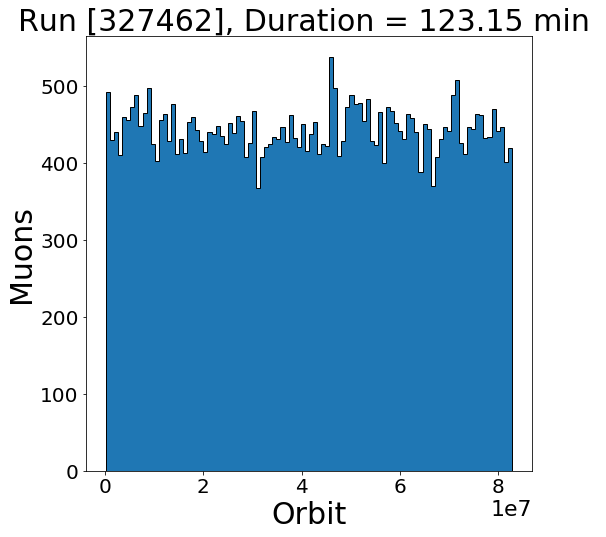

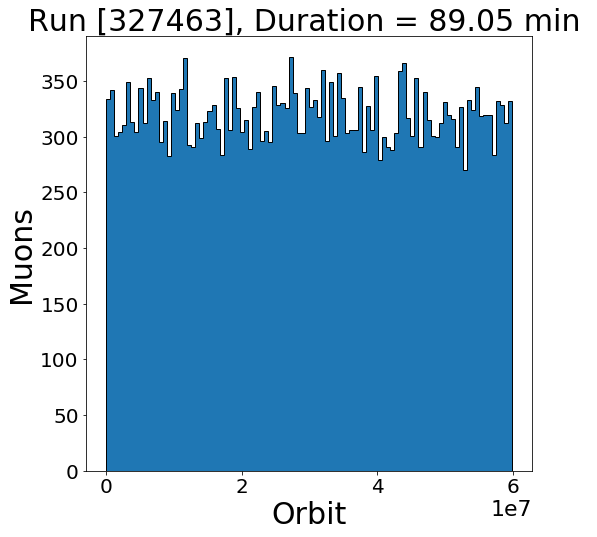

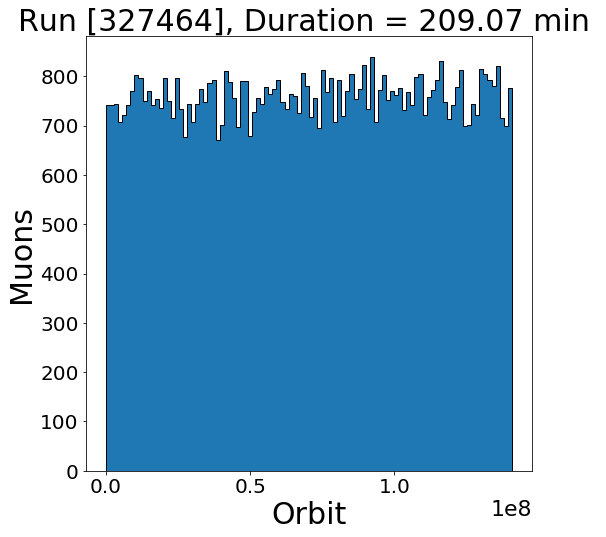

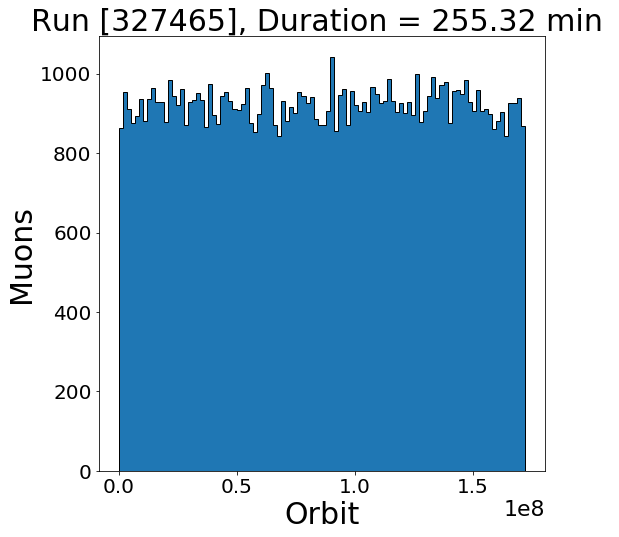

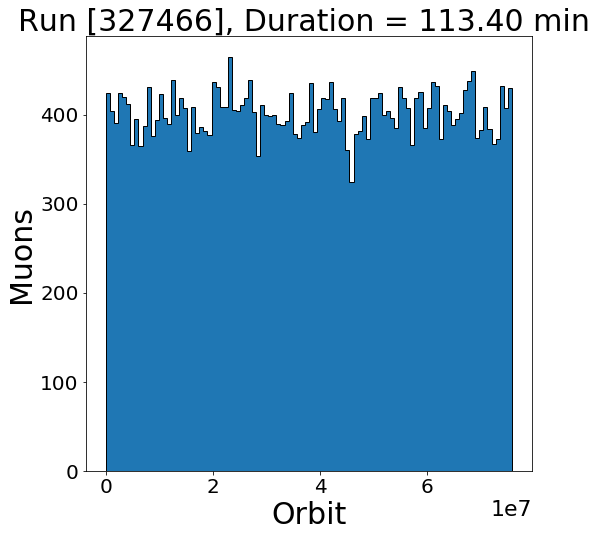

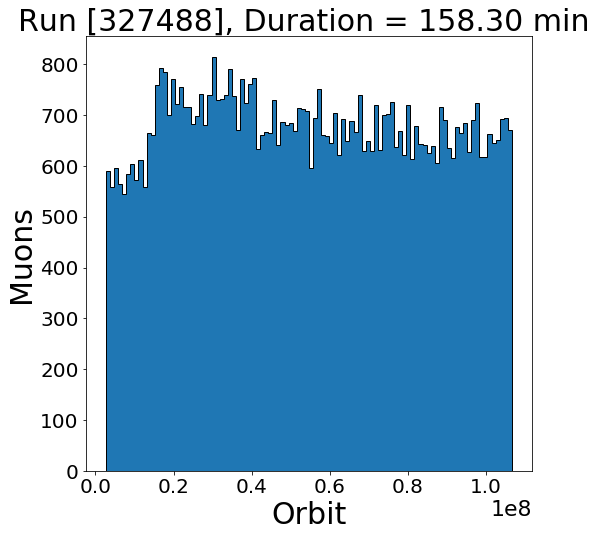

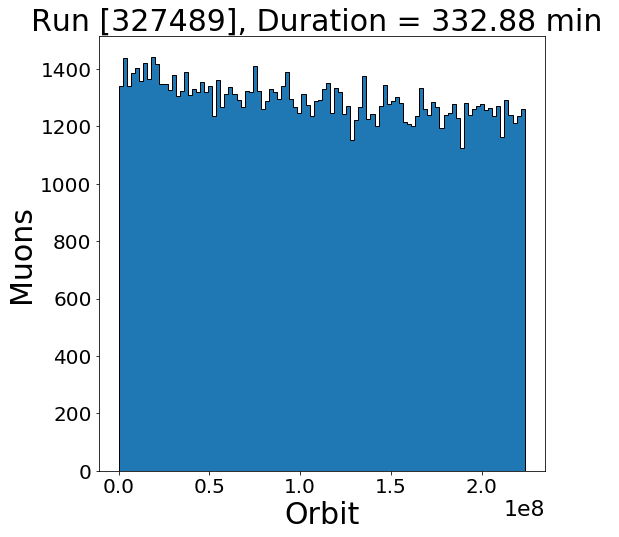

In [22]:
for run in runs:
    run.plotOrbit(bins = 100)

In [23]:
# After reviewing the graphs above, we classify our runs:
badrunNo = [326262, 326303, 326587, 327378, 327424, 327430, 327455, 327488, 327489]
badruns = [run for run in runs if run.run in badrunNo]
goodruns = [run for run in runs if run.run not in badrunNo]

In [24]:
# Write good and bad runs to the Tree
        
for run in goodruns:
    name = str(run.run)+".txt"
    run.df.to_csv("./data/goodRuns/csv/"+name, index = False) 
    for i in range(3):
        OS, SS = pair(run.df,i+1)
        OS.to_csv("./data/2LegGood/DBx{}/OS/".format(i+1)+name, index = False)
        SS.to_csv("./data/2LegGood/DBx{}/SS/".format(i+1)+name, index = False) 
    
for run in badruns:
    name = str(run.run)+".txt"
    run.df.to_csv("./data/badRuns/csv/"+name, index = False) 
    for i in range(3):
        OS, SS = pair(run.df,i+1)
        OS.to_csv("./data/2LegBad/DBx{}/OS/".format(i+1)+name, index = False)
        SS.to_csv("./data/2LegBad/DBx{}/SS/".format(i+1)+name, index = False) 
    